<a href="https://colab.research.google.com/github/fiapdatanalytics/tech-challenge4/blob/main/tech_challenge_4_algoritmos_de_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tech Challenge 4 - Data viz and production models**

## **Desafio**

🎯 Objetivo do Projeto

Desenvolver um modelo preditivo de Machine Learning para auxiliar uma equipe médica a diagnosticar níveis de nivel_obesidade em pacientes, com assertividade mínima de 75%, deployado em uma aplicação Streamlit, acompanhado de dashboard analítico e vídeo de apresentação.

🧩 Entregáveis Principais

* Pipeline de Machine Learning
* Feature engineering, treinamento e avaliação do modelo.
* Modelo com acurácia ≥ 75%
* Deploy no Streamlit
* Aplicação funcional acessível por link público.
* Dashboard analítico
* Visualização dos principais insights.
* Documentação (.doc ou .txt)
* Links do app, dashboard e repositório GitHub.
* Vídeo de apresentação (4 a 10 minutos)


# **Bibliotecas**

In [ ]:
import pandas as pd
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import requests
import numpy as np
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder # Outra opção é usar LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC



# **Funções**

## **Dicionario dados**

In [ ]:
def criar_novo_dicionario_dados(df: pd.DataFrame) -> dict:
    """
    Cria um novo dicionário de dados com uma estrutura inicial para cada coluna do DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame cujas colunas serão usadas para criar o dicionário.

    Returns:
        dict: O novo dicionário de dados.
    """
    try:
        novo_dicionario = {}
        for coluna in df.columns:
            novo_dicionario[coluna] = {
                'nome_original': coluna,
                'tipo_coluna': 'original',
                'novo_nome': None,
                'descricao': None,
                'transformacao': {} # Inicializa como um dicionário vazio
            }
        print("Novo dicionário de dados criado.")
        return novo_dicionario
    except Exception as e:
        print(f"Ocorreu um erro ao criar o novo dicionário de dados: {e}")
        return None

### **Atualiza de forma manual das colunas do dicionario de dados**

In [ ]:
def atualizar_campo_dicionario(dicionario: dict, coluna: str, campo: str, novo_valor):
    """
    Atualiza um campo específico para uma coluna no dicionário de dados.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        coluna (str): O nome da coluna (chave no dicionário) cujo campo será atualizado.
        campo (str): O nome do campo a ser atualizado ('nome_original', 'novo_nome', 'descricao', 'transformacao').
        novo_valor: O novo valor para o campo especificado.
    """
    try:
        if coluna in dicionario:
            if campo == 'nome_original':
                print(f"Erro: Não é permitido atualizar o campo 'nome_original'.")
            elif campo in dicionario[coluna]:
                 # Para o campo 'transformacao', adiciona os itens do novo_valor (espera-se um dicionário)
                 if campo == 'transformacao' and isinstance(novo_valor, dict):
                      # Check if the existing 'transformacao' field is actually a dictionary
                      if not isinstance(dicionario[coluna][campo], dict):
                           print(f"Aviso: O campo 'transformacao' para a coluna '{coluna}' não é um dicionário. Inicializando como dicionário vazio.")
                           dicionario[coluna][campo] = {} # Initialize if it's not a dict (should not happen with other fixes, but for safety)
                      # Assume que dicionario[coluna][campo] já é um dicionário (inicializado nas funções de criação/adição)
                      dicionario[coluna][campo].update(novo_valor)
                      print(f"Campo '{campo}' da coluna '{coluna}' atualizado com novos itens.")
                 else:
                     dicionario[coluna][campo] = novo_valor
                     print(f"Campo '{campo}' da coluna '{coluna}' atualizado para: '{novo_valor}'")
            else:
                print(f"Erro: O campo '{campo}' não existe para a coluna '{coluna}' no dicionário de dados.")
        else:
            print(f"Erro: A coluna '{coluna}' não foi encontrada no dicionário de dados.")
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o campo '{campo}' para a coluna '{coluna}': {e}")

### **Atualiza nomes dicionario**

In [ ]:
def atualizar_dicionario_renomeacao(dicionario: dict, mapa_colunas: dict):
    """
    Atualiza o dicionário de dados com base nas renomeações de colunas aplicadas.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        mapa_colunas (dict): Dicionário com o mapeamento de renomeação de colunas (nome_original: novo_nome).
    """
    try:
        print("Iniciando a atualização do dicionário de dados com renomeações...")

        # Crie uma copia das chaves para iterar sem problemas ao modificar o dicionário original
        chaves_originais = list(dicionario.keys())

        # Processar entradas e renomeacoes existentes
        for chave_original in chaves_originais:
            if chave_original in dicionario: # Verifica se a chave ainda existe
                info = dicionario[chave_original]
                nome_original = info.get('nome_original')
                novo_nome_existente = info.get('novo_nome') # Obtem o novo_nome potencialmente existente

                # Verifica se o nome da coluna original está no mapa de renomeação
                if nome_original in mapa_colunas:
                    atualiza_novo_nome = mapa_colunas[nome_original]

                   # Se a chave atual no dicionário não for o novo nome do mapa,
                   # e ainda não estiver definida com um novo nome diferente, atualize a chave e as informacoes.
                   # Esta condição lida tanto com renomeações iniciais quanto com casos em que uma coluna recebeu
                   # manualmente um novo_nome antes da aplicação do mapa de renomeacao.
                    if chave_original != atualiza_novo_nome and (novo_nome_existente is None or novo_nome_existente != atualiza_novo_nome):
                         # Copie as informacoes para a nova chave antes de excluir a antiga
                         dicionario[atualiza_novo_nome] = dicionario.pop(chave_original)
                         info = dicionario[atualiza_novo_nome] # Update info to point to the new key


                    info['novo_nome'] = atualiza_novo_nome # Atualiza novo_nome no dicionário info


                    # Certifica de que 'transformacao' seja um dicionário
                    if not isinstance(info.get('transformacao'), dict):
                        info['transformacao'] = {}
                    # Adiciona transformacao de renomeacao se ainda nao estiver presente
                    renome_desc = f"Renomeada de '{nome_original}' para '{atualiza_novo_nome}'."
                    if renome_desc not in info['transformacao'].values():
                         transform_key = f"transformacao_{len(info['transformacao']) + 1}"
                         info['transformacao'][transform_key] = renome_desc
                # Se a coluna nao estiver em mapa_colunas, mas tiver um novo_nome, certifique-se de que a chave do dicionario seja o novo_nome
                # Esta parte pode ser menos relevante para uma funcao de renomeacao dedicada, mas mantendo
                # uma verificacao do novo_nome existente para garantir a consistência do dicionario.
                elif novo_nome_existente is not None and chave_original != novo_nome_existente:
                     # Se a chave atual nao corresponder ao novo_nome existente, atualize a chave
                     if novo_nome_existente in dicionario:
                          # indica se um conflito ou erro nas etapas anteriores
                          print(f"Aviso: Conflito ao renomear. '{chave_original}' tem novo_nome '{novo_nome_existente}', mas '{novo_nome_existente}' já existe no dicionário.")
                     else:
                          dicionario[novo_nome_existente] = dicionario.pop(chave_original)
                          info = dicionario[novo_nome_existente] # Atualiza informacao para apontar para a nova chave


        print("Dicionário de dados atualizado com renomeações.")
        # dicionario modicado inplace
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário de dados com renomeações: {e}")


### **Atualiza Dicionario com as novas colunas criadas**

In [ ]:
def atualizar_dicionario_novas_colunas(dicionario: dict, df: pd.DataFrame):
    """
    Atualiza o dicionário de dados com informações sobre colunas recém-criadas no DataFrame.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        df (pd.DataFrame): O DataFrame com as colunas recém-criadas.
    """
    print("Iniciando a atualização do dicionário de dados com novas colunas...")
    try:
        colunas_atuais = df.columns.tolist()
        # Encontra colunas no DataFrame que não estão presentes no dicionário por seu 'novo_nome'
        # Precisamos considerar tanto a chave original quanto o novo_nome para verificar a existência
        existing_keys_and_new_names = set()
        for key, info in dicionario.items():
            existing_keys_and_new_names.add(key)
            if info.get('novo_nome'):
                existing_keys_and_new_names.add(info['novo_nome'])


        novas_colunas = [col for col in colunas_atuais if col not in existing_keys_and_new_names]

        for nova_coluna in novas_colunas:
            # Adiciona uma nova entrada ao dicionário para a nova coluna
            # Inicializa 'transformacao' como um dicionário vazio
            dicionario[nova_coluna] = {
                'nome_original': nova_coluna,
                'tipo_coluna' : 'criada',
                'novo_nome': None,
                'descricao': None,
                'transformacao': {} # Inicializa como um dicionário vazio
            }
            print(f"Adicionada nova coluna '{nova_coluna}' ao dicionário de dados.")


        print("Dicionário de dados atualizado com novas colunas.")
        return dicionario # Retorna explicitamente o dicionário atualizado
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário com novas colunas: {e}")
        return None # Retorna Nenhum em caso de erro

### **Atualiza campo descricao do dicionario em lote**

In [ ]:
def atualizar_descricoes_dicionario(dicionario: dict, descricoes: dict):
    """
    Atualiza o campo 'descricao' no dicionário de dados com base em um dicionário de descrições.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        descricoes (dict): O dicionário contendo as descrições (chave: nome da coluna, valor: descrição).

    Returns:
        int: A quantidade de descrições atualizadas.
    """
    quantidade_linhas_atualizadas = 0
    try:

        if not isinstance(descricoes, dict):
            print("Erro: O argumento 'descricoes' deve ser um dicionário.")
            return 0

        for chave in dicionario:
            if chave in descricoes:

                atualizar_campo_dicionario(dicionario, chave, 'descricao', descricoes[chave])
                quantidade_linhas_atualizadas += 1

        print(f'Quantidade de descrições atualizadas: {quantidade_linhas_atualizadas}.')
        return quantidade_linhas_atualizadas
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar as descrições no dicionário: {e}")
        return 0 # # Retorna 0 ou gera novamente a exceca




## **Funções de Transformação**

### **Renomear Colunas**

In [ ]:
def renomear_colunas(df: pd.DataFrame, mapa_renomeacao: dict = None, dicionario: dict = None) -> None:
    """
    Renomeia as colunas de um DataFrame utilizando um dicionário fornecido
    ou aplicando um padrão de formatação (minúsculas, espaços por '_').
    Se o padrão de formatação for aplicado, o dicionário de mapeamento gerado
    é salvo em um arquivo JSON chamado 'renaming_map_pattern.json'.
    Opcionalmente, atualiza um dicionário de dados com as renomeações.

    Args:
        df (pd.DataFrame): O DataFrame cujas colunas serão renomeadas.
        mapa_renomeacao (dict, optional): Um dicionário mapeando nomes de colunas originais para novos nomes.
                                         Se None, um padrão de formatação será aplicado.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    colunas_originais = df.columns.tolist()
    num_linhas_antes, num_colunas_antes = df.shape

    print("Número de linhas e colunas antes da transformação:")
    print(f"Linhas: {num_linhas_antes}, Colunas: {num_colunas_antes}")
    print(f"\nNomes das colunas originais:\n{colunas_originais}\n")

    try:
        if mapa_renomeacao:
            # Verificar se o dicionário fornecido tem chaves que correspondem às colunas do DataFrame
            if any(col in mapa_renomeacao for col in colunas_originais):
                df.rename(columns=mapa_renomeacao, inplace=True) # Modifica in-place
                print("Utilizado dicionário de renomeação fornecido.")
            else:
                print("Dicionário de renomeação fornecido, mas nenhuma chave corresponde às colunas existentes.")
                print("Aplicando padrão de formatação como alternativa.")
                # Aplicar padrão se o dicionário não corresponder
                mapa_nova_coluna = {}
                nova_coluna = []
                for col in colunas_originais:
                    col_caixa_baixa = col.lower()
                    col_limpa = col_caixa_baixa.strip()
                    col_formatada = re.sub(r'\s+', '_', col_limpa)
                    nova_coluna.append(col_formatada)
                    mapa_nova_coluna[col] = col_formatada
                df.columns = nova_coluna # Modifica in-place
                print("Padrão de formatação aplicado.")
                # Salva mapa gerado em JSON
                with open(f'mapeamento_coluna_{df}.json', 'w') as f:
                    json.dump(mapa_nova_coluna, f, indent=4)
                print(f"Dicionário de renomeação gerado pelo padrão salvo em f'mapeamento_coluna_{df}.json'.")
                # Usa o mapa gerado para atualização do dicionário
                mapa_renomeacao_aplicado = mapa_nova_coluna
        else:
            # Aplicar padrão de formatação se nenhum dicionário for fornecido
            print("Nenhum dicionário de renomeação fornecido. Aplicando padrão de formatação.")
            mapa_nova_coluna = {}
            nova_coluna = []
            for col in colunas_originais:
                col_caixa_baixa = col.lower()
                col_limpa = col_caixa_baixa.strip()
                col_formatada = re.sub(r'\s+', '_', col_limpa)
                nova_coluna.append(col_formatada)
                mapa_nova_coluna[col] = col_formatada
            df.columns = nova_coluna # Modifica in-place
            print("Padrão de formatação aplicado.")
            # Salva mapa gerado em JSON
            with open(f'mapeamento_coluna_{df}.json', 'w') as f:
                json.dump(mapa_nova_coluna, f, indent=4)
            print(f"Dicionário de renomeação gerado pelo padrão salvo em f'mapeamento_coluna_{df}.json'.")
            # Usa o mapa gerado para atualização do dicionário
            mapa_renomeacao_aplicado = mapa_nova_coluna


        colunas_modificadas = df.columns.tolist()
        num_linhas_depois, num_colunas_depois = df.shape

        print(f"\nNomes das colunas modificadas:\n{colunas_modificadas}\n")
        print("Número de linhas e colunas após a transformação:")
        print(f"Linhas: {num_linhas_depois}, Colunas: {num_colunas_depois}")

        # Atualizar o dicionário de dados com as renomeações, se fornecido
        if dicionario is not None:
            # Se um mapa_renomeacao específico foi fornecido e usado, use-o para a atualização do dicionário
            # Caso contrário, utilize o mapa_nova_coluna gerado automaticamente (que agora e mapa_renomeacao_aplicado)
            mapa_para_atualizar_dicionario = mapa_renomeacao if mapa_renomeacao and any(col in mapa_renomeacao for col in colunas_originais) else mapa_renomeacao_aplicado

            atualizar_dicionario_renomeacao(dicionario, mapa_para_atualizar_dicionario)


    except NameError as e:
        print(f"Ocorreu um erro de nome ao renomear as colunas: {e}")
    except Exception as e: # Mantendo um except geral para outros tipos de erro inesperados
        print(f"Ocorreu um erro inesperado ao renomear as colunas: {e}")

### **Transforma valores de uma coluna de string para string**

In [ ]:
def transformar_valores_string(df: pd.DataFrame, coluna: str, mapa_transformacao: dict, dicionario: dict = None):
    """
    Transforma os valores de uma coluna do tipo string para string utilizando um mapeamento,
    salva a alteração e atualiza o dicionário de dados.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser transformada.
        mapa_transformacao (dict): Um dicionário contendo o mapeamento dos valores originais para os novos valores.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if df[coluna].dtype != 'object':
        print(f"Erro: A coluna '{coluna}' não é do tipo 'object'. Nenhuma transformação será aplicada.")
        return

    try:
        # Verificar se todos os valores únicos na coluna estão no mapeamento
        valores_unicos_na_coluna = df[coluna].dropna().unique()
        valores_nao_mapeados = [valor for valor in valores_unicos_na_coluna if valor not in mapa_transformacao]

        if valores_nao_mapeados:
            print(f"Erro: Os seguintes valores únicos na coluna '{coluna}' não foram encontrados no mapeamento:")
            print(valores_nao_mapeados)
            print("A transformação não será realizada pois nem todos os valores possuem um mapeamento.")
            return # Adicionado para sair da função se houver valores não mapeados


        # Contar linhas antes da alteração
        linhas_antes = df.shape[0]

        # Aplicar a transformação
        df[coluna] = df[coluna].map(mapa_transformacao)

        # Contar linhas após a alteração
        linhas_depois = df.shape[0]
        linhas_alteradas = linhas_antes # Neste caso, todas as linhas da coluna são "alteradas" pelo mapeamento


        print(f"Coluna '{coluna}' transformada com sucesso.")
        print(f"Tipo de alteração: Mapeamento de valores string para string.")
        print(f"Número de linhas processadas: {linhas_alteradas}")

        # Exibir valores únicos e contagem depois da transformação
        print(f"\nValores únicos e contagem depois da transformação para a coluna '{coluna}':")
        display(df[coluna].value_counts(dropna=False))

        # Salvar a alteração em uma variável e atualizar o dicionário de dados, se fornecido
        if dicionario is not None:
            alteracao = {
                'tipo': 'mapeamento_string_para_string',
                'mapa_aplicado': mapa_transformacao
            }
            atualizar_campo_dicionario(dicionario, coluna, 'transformacao', alteracao)


    except Exception as e:
        print(f"Ocorreu um erro ao transformar a coluna '{coluna}': {e}")

### **Transforma valores de uma coluna de string para numero**

In [ ]:
def codificar_coluna_categorica(df: pd.DataFrame, coluna: str, transformacoes_categoricas: list, dicionario: dict = None):
    """
    Transforma os valores únicos de uma coluna do tipo 'object' em números inteiros,
    reutilizando mapeamentos existentes para conjuntos idênticos de valores únicos
    e armazenando novos mapeamentos. Opcionalmente, atualiza um dicionário de dados
    com a transformação realizada.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser codificada.
        transformacoes_categoricas (list): Uma lista de dicionários contendo mapeamentos de transformações já realizadas.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if df[coluna].dtype != 'object':
        print(f"A coluna '{coluna}' não é do tipo 'object'. Nenhuma codificação será aplicada.")
        return

    try:
        # Contar valores nulos antes da transformação
        nulos_antes = df[coluna].isnull().sum()

        # Obter e imprimir valores únicos e contagem antes da transformação
        print(f"Valores únicos e contagem antes da codificação para a coluna '{coluna}':")
        display(df[coluna].value_counts())

        # Obter valores únicos da coluna atual, excluindo nulos e ordenando para comparação consistente
        valores_unicos_atuais = sorted(df[coluna].dropna().unique().tolist())

        # Verificar se existe um mapeamento correspondente na lista de transformações
        mapa_encontrado = None
        for trans in transformacoes_categoricas:
            if sorted(trans['valores_originais']) == valores_unicos_atuais:
                mapa_encontrado = trans['mapa']
                print(f"Utilizando mapeamento existente para a coluna '{coluna}'.")
                break

        if mapa_encontrado:
            mapa_codificacao = mapa_encontrado
        else:
            # Criar um novo mapa de transformação se nenhum for encontrado
            mapa_codificacao = {valor: i for i, valor in enumerate(valores_unicos_atuais)}
            # Armazenar o novo mapeamento na lista de transformações
            transformacoes_categoricas.append({
                'valores_originais': valores_unicos_atuais,
                'mapa': mapa_codificacao
            })
            print(f"Criando novo mapeamento para a coluna '{coluna}'.")


        # Imprimir o mapa de codificação utilizado
        print(f"\nMapeamento aplicado para a coluna '{coluna}':")
        print(mapa_codificacao)

        # Contar linhas antes da alteração
        linhas_antes = df.shape[0]

        # Aplicar a codificação
        df[coluna] = df[coluna].map(mapa_codificacao)

        # Contar linhas após a alteração (devem ser as mesmas, mas é bom para verificar)
        linhas_depois = df.shape[0]
        linhas_alteradas = linhas_antes # Neste caso, todas as linhas da coluna são "alteradas" pelo mapeamento


        # Verificar se surgiram nulos inesperados
        nulos_depois = df[coluna].isnull().sum()
        if nulos_depois > nulos_antes:
            print(f"Aviso: A transformação da coluna '{coluna}' resultou em {nulos_depois - nulos_antes} valores nulos inesperados.")
            print("Verifique o mapa de codificação ou os valores originais na coluna.")

        print(f"\nColuna '{coluna}' codificada com sucesso.")
        print(f"Tipo de alteração: Mapeamento de valores únicos para inteiros.")
        print(f"Número de linhas processadas: {linhas_alteradas}")

        # Obter e imprimir valores únicos e contagem depois da transformação
        print(f"\nValores únicos e contagem depois da codificação para a coluna '{coluna}':")
        display(df[coluna].value_counts())

        # Atualizar o dicionário de dados, se fornecido
        if dicionario is not None:
             if coluna in dicionario:
                 alteracao = {
                     f'transformacao_{len(dicionario[coluna].get("transformacao", {})) + 1}': f"Mapeado para inteiros usando o mapa: {mapa_codificacao}"
                 }
                 atualizar_campo_dicionario(dicionario, coluna, 'transformacao', alteracao)
                 print(f"Dicionário de dados atualizado para a coluna '{coluna}'.")
             else:
                 print(f"Erro: A coluna '{coluna}' não foi encontrada no dicionário de dados para atualização.")


    except Exception as e:
        print(f"Ocorreu um erro ao codificar a coluna '{coluna}': {e}")

## **Funções de Análise**

### **Análisar Colunas do Tipo 'object' em um DataFrame**

In [ ]:
def analisar_colunas_objeto(df: pd.DataFrame):
    """
    Identifica e analisa colunas do tipo 'object' em um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.
    """
    objetos_colunas = df.select_dtypes(include='object').columns
    print("Colunas do tipo 'object' restantes:")
    print(objetos_colunas)

    # Analizando valores unicos para cada coluna
    for col in objetos_colunas:
        print(f"\nValores únicos para a coluna '{col}':")
        display(df[col].unique())
        print(f"Contagem de valores para a coluna '{col}':")
        display(df.groupby(col).size())

### **Histograma**

In [ ]:
def gera_histograma(df: pd.DataFrame, coluna: str, titulo: str):
    """
    Gera um histograma para uma coluna específica de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        coluna (str): O nome da coluna para gerar o histograma.
        titulo (str): O título do gráfico.
    """
    plt.figure(figsize=(10, 6))
    # Usando o argumento 'color' para definir uma cor única para o histograma.
    # Escolhendo uma cor da paleta 'colorblind'.
    sns.histplot(data=df, x=coluna, kde=True, color=sns.color_palette('colorblind')[1]) # Using the first color from 'colorblind' palette
    plt.title(titulo)
    plt.xlabel(coluna)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Frequência")
    plt.show()

### **Gráfico barras**

In [ ]:
def gera_grafico_barras(df: pd.DataFrame, x_col: str, y_col: str = None, hue_col: str = None, titulo: str = None):
    """
    Gera um gráfico de barras usando Seaborn.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        x_col (str): O nome da coluna para o eixo X.
        y_col (str, optional): O nome da coluna para o eixo Y (para barplot).
                               Se None, gera um countplot (contagem de ocorrências).
        hue_col (str, optional): O nome da coluna para dividir as barras por cor. Defaults to None.
        title (str, optional): O título do gráfico. Defaults to "Gráfico de Barras".
    """
    plt.figure(figsize=(12, 6))

    if y_col:
        # Gera um barplot se y_col for fornecido (para exibir valores em y)
        # Ajuste para o FutureWarning: Passar x_col para hue quando hue_col é None e set legend=False
        if hue_col is None:
            sns.barplot(data=df, x=x_col, y=y_col, hue=x_col, palette='colorblind', legend=False)
        else:
             # Se hue_col for especificado, use-o
             sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind')
        plt.ylabel(y_col)
    else:
        # Gera um countplot se y_col não for fornecido (para exibir contagens)
        if hue_col is None:
            sns.countplot(data=df, x=x_col, hue=x_col, palette='colorblind', order=df[x_col].value_counts().index, legend=False) # Ordena por contagem
        else:
            sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=df[x_col].value_counts().index) # Ordena por contagem
        plt.ylabel("Contagem")


    plt.title(titulo)
    plt.xlabel(x_col)
    plt.xticks(rotation=45, ha='right') # Rotaciona rótulos do eixo X para melhor leitura
    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show()

## **Funções gerais**

### **Leitura de arquivo json de uma URL**

In [ ]:
def ler_json_de_url(url: str) -> dict:
    """
    Lê um arquivo JSON de uma URL fornecida.

    Args:
        url (str): A URL do arquivo JSON.

    Returns:
        dict: O dicionário de dados carregado do arquivo JSON, ou Nenhum se ocorrer um erro.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # HTTPError por resostas (4xx or 5xx)
        data_dict = response.json()
        print(f"Leitura com sucesso do caminho {url}")
        return data_dict
    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar a URL {url}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"Erro: Não foi possível decodificar JSON da URL {url}. Verifique o formato do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao ler de {url}: {e}")
        return None

### **Funcao de classificacao para coluna**

In [ ]:
def classificar_coluna_por_config(df: pd.DataFrame, coluna_original: str, nova_coluna: str, config: dict) -> pd.DataFrame:
    """
    Classifica os valores de uma coluna numérica em categorias usando um dicionário de configuração.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna_original (str): O nome da coluna numérica a ser classificada.
        nova_coluna (str): O nome da nova coluna que conterá as categorias.
        config (dict): O dicionário de configuração com 'bins', 'labels', 'right', 'include_lowest'.

    Returns:
        pd.DataFrame: O DataFrame com a nova coluna de classificação adicionada, ou o DataFrame original em caso de erro.
    """
    if coluna_original not in df.columns:
        print(f"Erro: A coluna original '{coluna_original}' não existe no DataFrame.")
        return df

    if not pd.api.types.is_numeric_dtype(df[coluna_original]):
         print(f"A coluna '{coluna_original}' não é do tipo numérico. Nenhuma classificação será aplicada.")
         return df

    try:
        # Validar se os parâmetros necessários estão no dicionário
        if 'bins' not in config or 'labels' not in config:
            print("Erro: O dicionário de configuração deve conter as chaves 'bins' e 'labels'.")
            return df

        bins = config['bins']
        labels = config['labels']
        right = config.get('right', True) # Padrão True se não especificado
        include_lowest = config.get('include_lowest', False) # Padrão False se não especificado

        # Tratar caso de bins com strings como "-inf", "inf"
        bins_processados = []
        for b in bins:
            if isinstance(b, str):
                if b.lower() == '-inf':
                    bins_processados.append(-np.inf)
                elif b.lower() == 'inf':
                    bins_processados.append(np.inf)
                else:
                    try:
                        bins_processados.append(float(b))
                    except ValueError:
                        print(f"Aviso: Valor inválido em 'bins': '{b}'. Mantendo como está ou pode causar erro.")
                        bins_processados.append(b) # Mantém o valor original se a conversão falhar
            else:
                bins_processados.append(b)


        # Realizar a classificação usando pd.cut
        # pd.cut requires bins to be sorted. Add a check here.
        if not all(bins_processados[i] <= bins_processados[i+1] for i in range(len(bins_processados)-1)):
             print("Erro: Os bins fornecidos no dicionário de configuração não estão em ordem crescente.")
             return df

        if len(bins_processados) != len(labels) + 1:
            print(f"Erro: O número de bins ({len(bins_processados)}) deve ser um a mais que o número de labels ({len(labels)}).")
            return df


        df[nova_coluna] = pd.cut(df[coluna_original], bins=bins_processados, labels=labels, right=right, include_lowest=include_lowest)

        print(f"Coluna '{coluna_original}' classificada com sucesso na nova coluna '{nova_coluna}'.")

        # Exibir a contagem de valores na nova coluna para verificar a distribuição
        print(f"\nContagem de valores para a nova coluna '{nova_coluna}':")
        display(df[nova_coluna].value_counts(dropna=False))


        return df # Retorna o DataFrame modificado
    except Exception as e:
        print(f"Ocorreu um erro ao classificar a coluna '{coluna_original}': {e}")
        return df

### **Leitura de Arquivo Json**

In [ ]:
def ler_arquivo_json(file_path: str) -> dict:
    """
    Reads a JSON file containing a data dictionary.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data dictionary loaded from the JSON file, or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as f:
            data_dict = json.load(f)
        print(f"Leitura com sucesso do caminho {file_path}")
        return data_dict
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check the file format.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while reading {file_path}: {e}")
        return None



### **Função para verificar valores nulos**

In [ ]:
def verificar_nulos_por_coluna(df: pd.DataFrame) -> None:
    """
    Verifica e imprime a quantidade de valores nulos por coluna em um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser verificado.
    """
    print("Verificando valores nulos por coluna:")
    try:
        nulos_por_coluna = df.isnull().sum()
        colunas_com_nulos = nulos_por_coluna[nulos_por_coluna > 0]

        if colunas_com_nulos.empty:
            print("Nenhuma coluna possui valores nulos.")
        else:
            print("\nColunas com valores nulos:")
            display(colunas_com_nulos)

    except Exception as e:
        print(f"Ocorreu um erro ao verificar valores nulos: {e}")

# Exemplo de uso (comente ou remova se não quiser executar imediatamente)
# verificar_nulos_por_coluna(df)

### **Criacao de CSV a partir de um dataframe**

In [ ]:
def criar_csv_de_dataframe(df: pd.DataFrame, nome_arquivo: str) -> None:
    """
    Gera um arquivo CSV a partir de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser salvo.
        nome_arquivo (str): O nome do arquivo CSV de saída (incluindo a extensão .csv).
    """
    if not isinstance(df, pd.DataFrame):
        print("Erro: O primeiro argumento deve ser um DataFrame do pandas.")
        return

    if not isinstance(nome_arquivo, str) or not nome_arquivo.lower().endswith('.csv'):
        print("Erro: O nome do arquivo deve ser uma string e terminar com '.csv'.")
        return

    try:
        df.to_csv(nome_arquivo, index=False)
        print(f"DataFrame salvo com sucesso em '{nome_arquivo}'")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o DataFrame em '{nome_arquivo}': {e}")

### **Criação de arquivo json a partir de um dicionario**

In [ ]:
def criar_json_de_dicionario(dicionario: dict, nome_arquivo: str) -> None:
    """
    Gera um arquivo JSON a partir de um dicionário Python.

    Args:
        dicionario (dict): O dicionário a ser salvo.
        nome_arquivo (str): O nome do arquivo JSON de saída (incluindo a extensão .json).
    """
    if not isinstance(dicionario, dict):
        print("Erro: O primeiro argumento deve ser um dicionário Python.")
        return

    if not isinstance(nome_arquivo, str) or not nome_arquivo.lower().endswith('.json'):
        print("Erro: O nome do arquivo deve ser uma string e terminar com '.json'.")
        return

    try:
        with open(nome_arquivo, 'w') as f:
            json.dump(dicionario, f, indent=4)
        print(f"Dicionário salvo com sucesso em '{nome_arquivo}'")
    except TypeError as e:
        print(f"Erro: O conteúdo do dicionário não é serializável para JSON. Detalhes: {e}")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o dicionário em '{nome_arquivo}': {e}")

# **Dados**

In [ ]:
# importando a base de dados obesidade.csv
df_obesidade = pd.read_csv('/content/obesidade_processado.csv')

In [ ]:
display(df_obesidade.head())

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,...,calc,classificacao_peso_corporal,imc,classificacao_imc,mtrans_Automobile,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking,classificacao_peso_corporal_encoded
0,0,-0.522124,-0.875589,-0.862558,1,0,2.0,0.404153,-0.300346,0,...,-1.419172,peso_normal,-0.662983,peso_normal,0,0,0,1,0,1.0
1,0,-0.522124,-1.947599,-1.168077,1,0,3.0,0.404153,-0.300346,1,...,0.521160,peso_normal,-0.681711,peso_normal,0,0,0,1,0,1.0
2,1,-0.206889,1.054029,-0.366090,1,0,2.0,0.404153,-0.300346,0,...,2.461491,peso_normal,-0.740392,peso_normal,0,0,0,1,0,1.0
3,1,0.423582,1.054029,0.015808,0,0,3.0,0.404153,-0.300346,0,...,2.461491,sobrepeso_tipo_1,-0.355847,sobrepeso,0,0,0,0,1,2.0
4,1,-0.364507,0.839627,0.122740,0,0,2.0,-2.167023,-0.300346,0,...,0.521160,sobrepeso_tipo_2,-0.169816,sobrepeso,0,0,0,1,0,3.0


In [ ]:
#importando o dicinário de dados

caminho_dicionario_dados = '/content/dicionario_dados_tech_challenge_4.json'

df_dicionario_dados = ler_arquivo_json(caminho_dicionario_dados)

Error: The file /content/dicionario_dados_tech_challenge_4.json was not found.


In [ ]:
display(df_dicionario_dados)

None

# Task
Create a step-by-step plan to train a machine learning model to predict obesity levels using the "obesidade.csv" dataset, where the target variable is "classificacao_peso_corporal_encoded".

## Exploração e visualização dos dados (pós-pré-processamento)

### Etapa 1:
Realizar uma análise exploratória dos dados já pré-processados para entender a distribuição das variáveis e a relação entre elas e a variável alvo.


Exibe as primeiras linhas do dataframe e verifique os tipos de dados para obter uma compreensão inicial dos dados pré-processados.



In [ ]:
display(df_obesidade.head())
display(df_obesidade.info())

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,...,calc,classificacao_peso_corporal,imc,classificacao_imc,mtrans_Automobile,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking,classificacao_peso_corporal_encoded
0,0,-0.522124,-0.875589,-0.862558,1,0,2.0,0.404153,-0.300346,0,...,-1.419172,peso_normal,-0.662983,peso_normal,0,0,0,1,0,1.0
1,0,-0.522124,-1.947599,-1.168077,1,0,3.0,0.404153,-0.300346,1,...,0.521160,peso_normal,-0.681711,peso_normal,0,0,0,1,0,1.0
2,1,-0.206889,1.054029,-0.366090,1,0,2.0,0.404153,-0.300346,0,...,2.461491,peso_normal,-0.740392,peso_normal,0,0,0,1,0,1.0
3,1,0.423582,1.054029,0.015808,0,0,3.0,0.404153,-0.300346,0,...,2.461491,sobrepeso_tipo_1,-0.355847,sobrepeso,0,0,0,0,1,2.0
4,1,-0.364507,0.839627,0.122740,0,0,2.0,-2.167023,-0.300346,0,...,0.521160,sobrepeso_tipo_2,-0.169816,sobrepeso,0,0,0,1,0,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   genero                               2111 non-null   int64  
 1   idade                                2111 non-null   float64
 2   altura                               2111 non-null   float64
 3   peso                                 2111 non-null   float64
 4   historico_familiar                   2111 non-null   int64  
 5   favc                                 2111 non-null   int64  
 6   fcvc                                 2111 non-null   float64
 7   ncp                                  2111 non-null   float64
 8   caec                                 2111 non-null   float64
 9   fumante                              2111 non-null   int64  
 10  ch20                                 2111 non-null   float64
 11  scc                           

None

Obtem um resumo estatístico das colunas numéricas e identifique as colunas categóricas para análise posterior, conforme as instruções.

**Colunas categóricas:** `colunas_categoricas`


In [ ]:
display(df_obesidade.describe())

colunas_categoricas = df_obesidade.select_dtypes(include='object').columns.tolist()
print("\nColunas categóricas:")
print(colunas_categoricas)

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,...,faf,tue,calc,imc,mtrans_Automobile,mtrans_Bike,mtrans_Motorbike,mtrans_Public_Transportation,mtrans_Walking,classificacao_peso_corporal_encoded
count,2111.000000,2111.000000,2.111000e+03,2.111000e+03,2111.000000,2111.000000,2111.000000,2.111000e+03,2.111000e+03,2111.000000,...,2111.000000,2.111000e+03,2.111000e+03,2.111000e+03,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,0.505921,0.000000,-5.385449e-16,-5.385449e-16,0.817622,0.883941,2.419043,5.032029e-16,-5.385449e-17,0.020843,...,0.000000,-6.731812e-18,5.048859e-17,2.154180e-16,0.216485,0.003316,0.005211,0.748460,0.026528,3.112269
std,0.500083,1.000237,1.000237e+00,1.000237e+00,0.386247,0.320371,0.533927,1.000237e+00,1.000237e+00,0.142893,...,1.000237,1.000237e+00,1.000237e+00,1.000237e+00,0.411946,0.057502,0.072015,0.434001,0.160737,1.985062
min,0.000000,-1.625448,-2.698006e+00,-1.817304e+00,0.000000,0.000000,1.000000,-2.167023e+00,-2.435125e+00,0.000000,...,-1.188039,-1.080625e+00,-1.419172e+00,-2.085052e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.688066,-7.683883e-01,-8.062914e-01,1.000000,1.000000,2.000000,-3.456952e-02,-3.003456e-01,0.000000,...,-1.041630,-1.080625e+00,-1.419172e+00,-6.710989e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,-0.241897,-1.263207e-02,-1.369510e-01,1.000000,1.000000,2.385502,4.041527e-01,-3.003456e-01,0.000000,...,-0.012109,-5.341135e-02,5.211595e-01,-1.223725e-01,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
75%,1.000000,0.265964,7.159595e-01,7.960531e-01,1.000000,1.000000,3.000000,4.041527e-01,-3.003456e-01,0.000000,...,0.771857,5.619968e-01,5.211595e-01,7.884258e-01,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
max,1.000000,5.782584,2.983646e+00,3.300136e+00,1.000000,1.000000,3.000000,1.689740e+00,3.969213e+00,1.000000,...,2.339750,2.204618e+00,4.401822e+00,2.635617e+00,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000



Colunas categóricas:
['classificacao_peso_corporal', 'classificacao_imc']


**Reasoning**:
Generate bar plots for the identified categorical columns to visualize their frequency distribution.



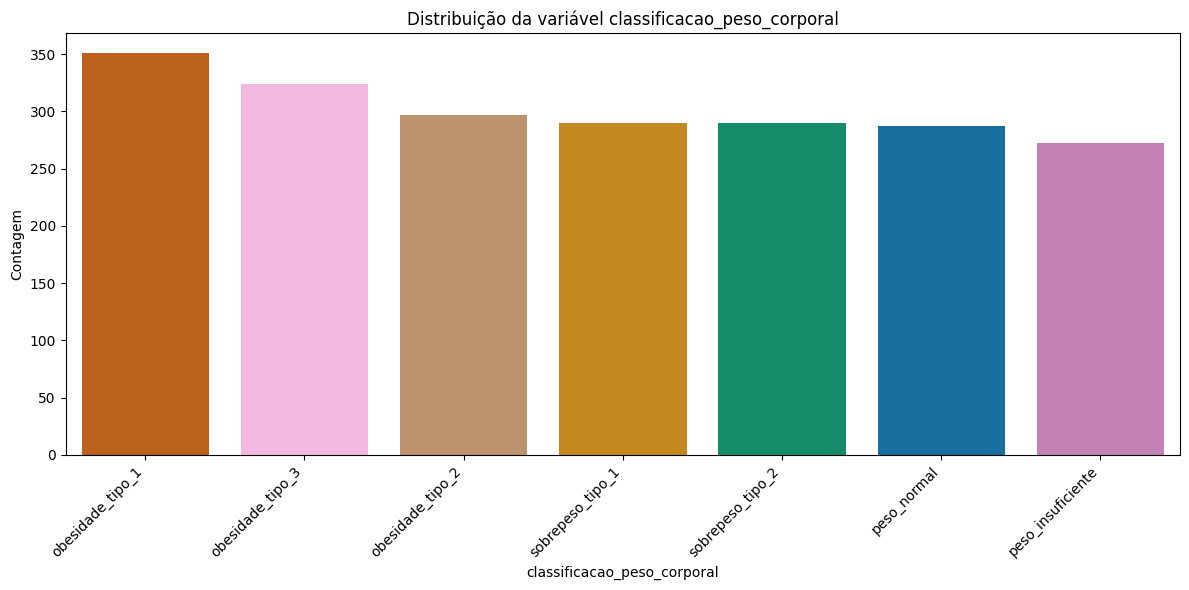

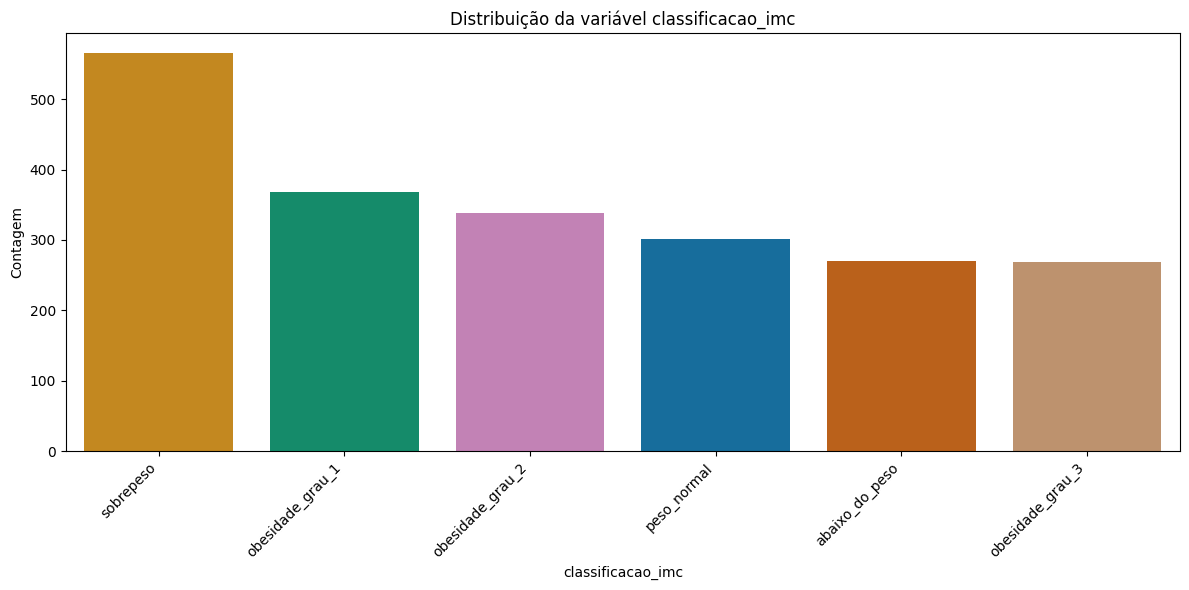

In [ ]:
for col in colunas_categoricas:
    gera_grafico_barras(df_obesidade, col, titulo=f'Distribuição da variável {col}')

Gera histogramas para colunas numéricas para visualizar suas distribuições e um gráfico de contagem para a variável de destino para ver a distribuição de classes.

**Variáveis numéricas:** `colunas_numericas`

**Variável alvo:** `coluna_alvo`



In [ ]:
coluna_alvo = 'classificacao_peso_corporal_encoded'
colunas_numericas = df_obesidade.select_dtypes(include=np.number).columns.tolist()
# Exclui a variável de destino das colunas numéricas para plotagem do histograma
colunas_numericas.remove(coluna_alvo)

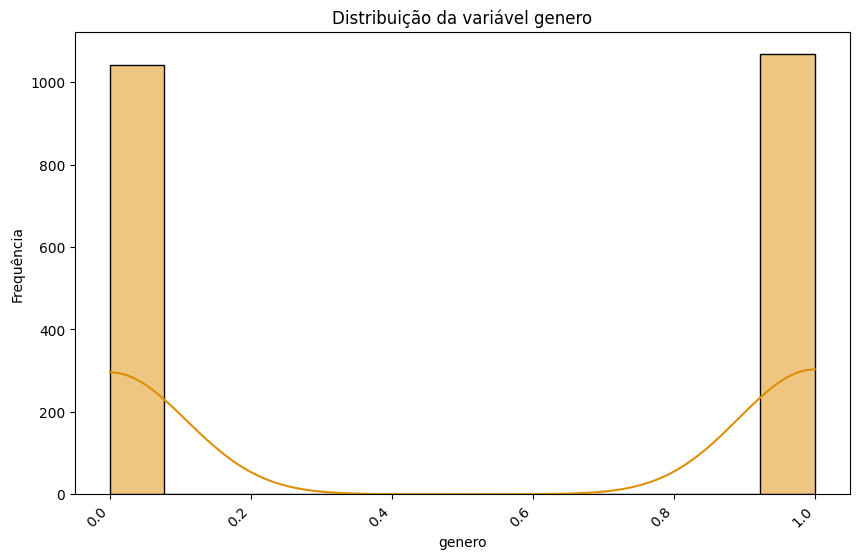

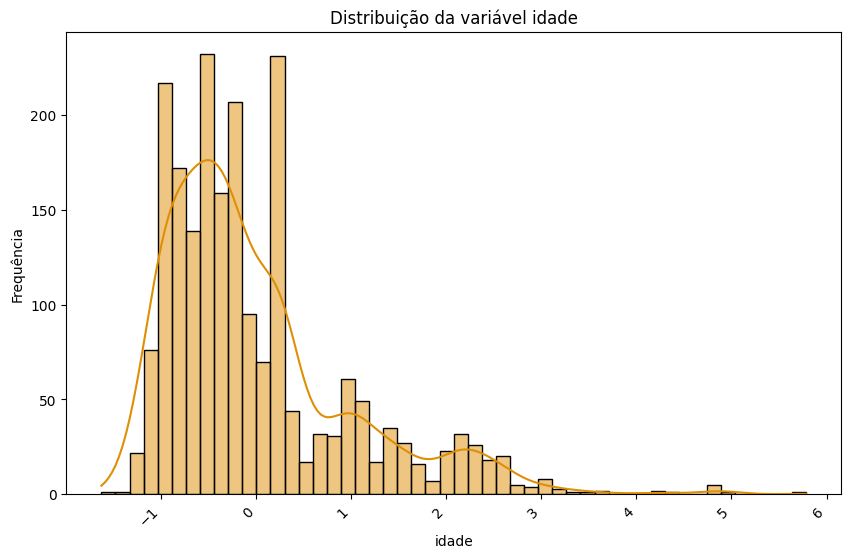

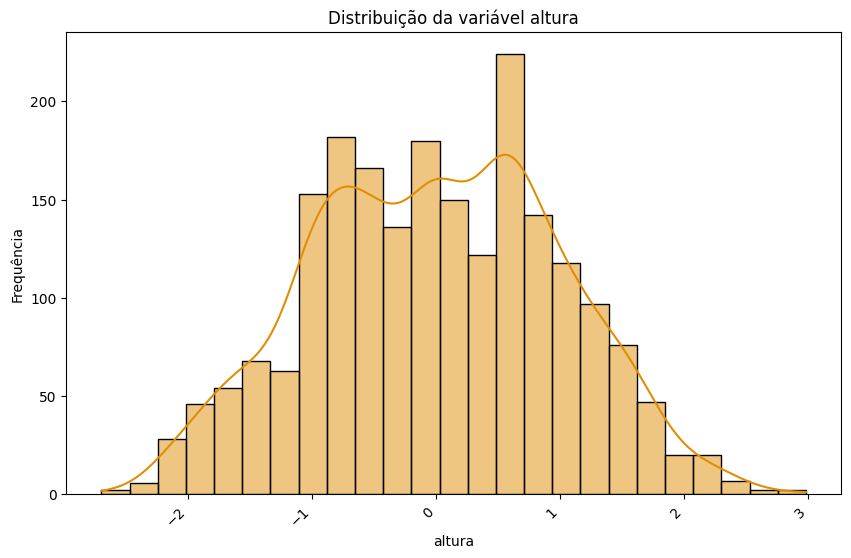

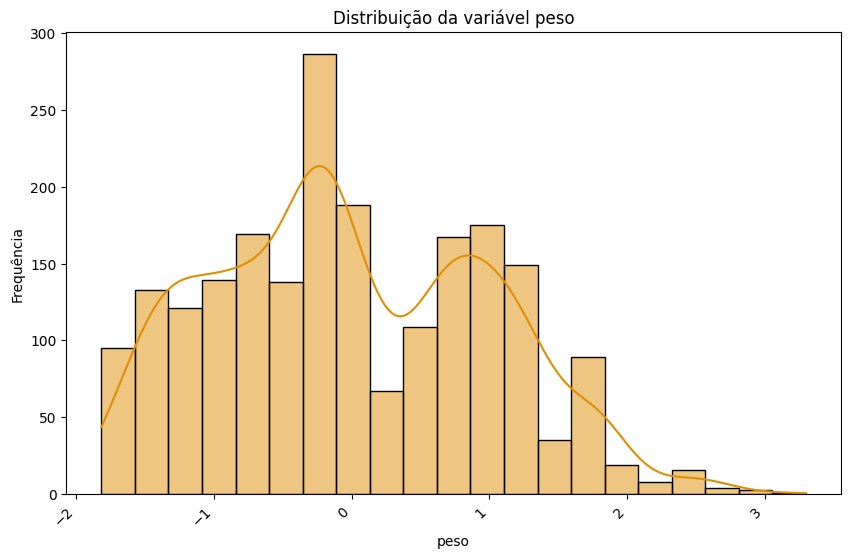

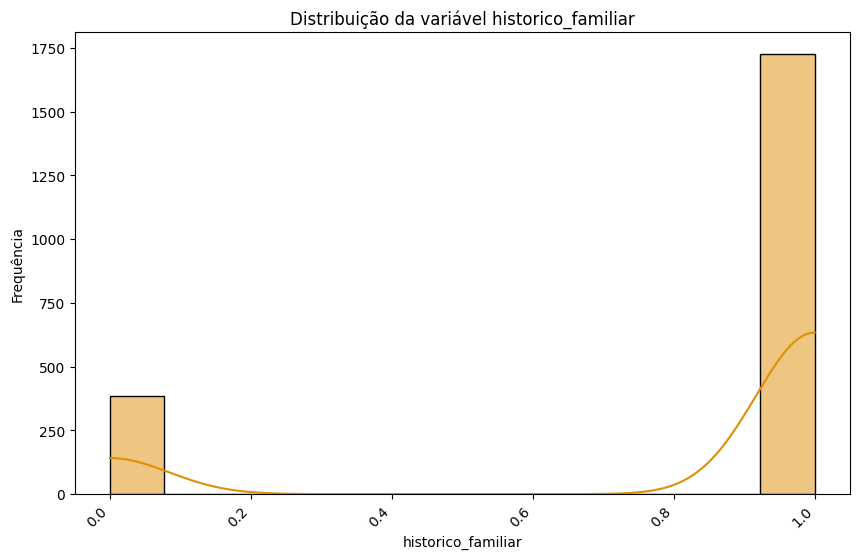

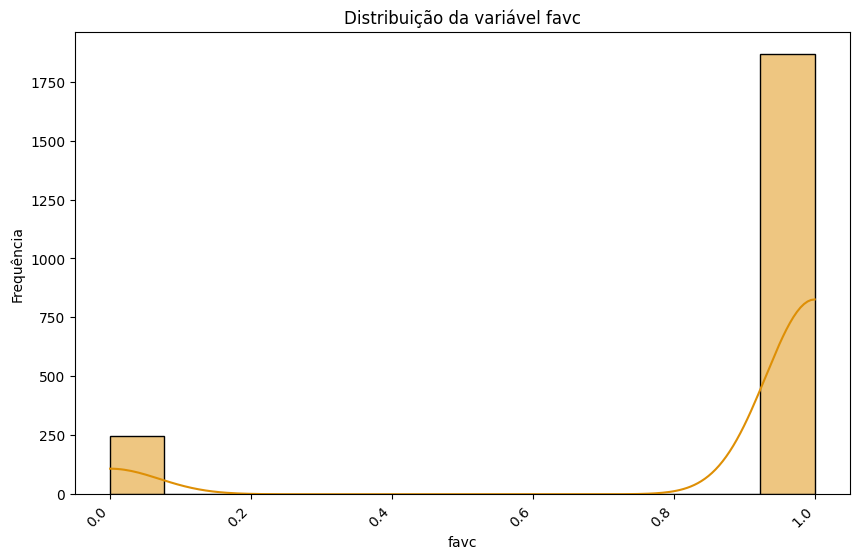

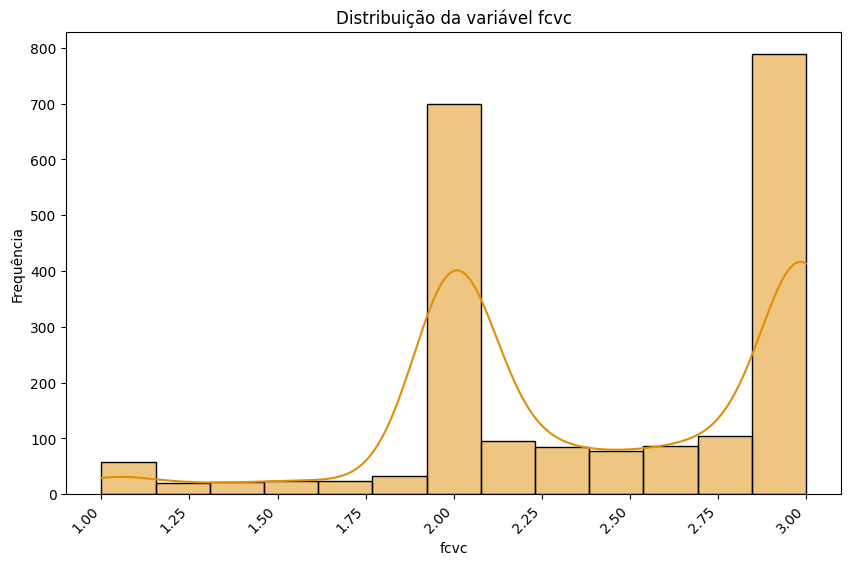

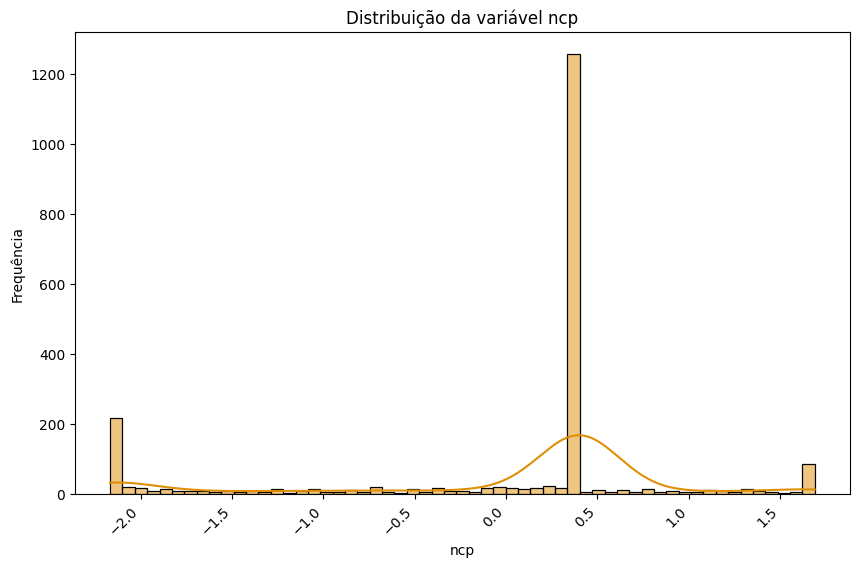

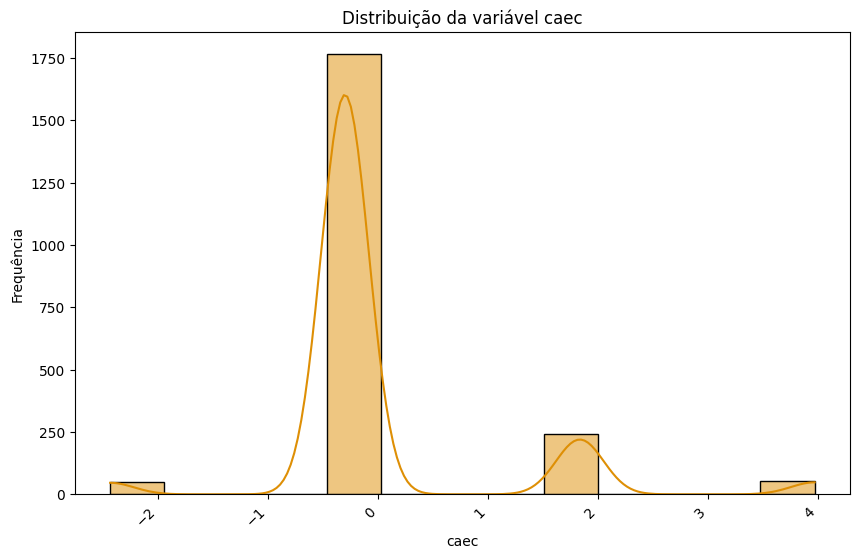

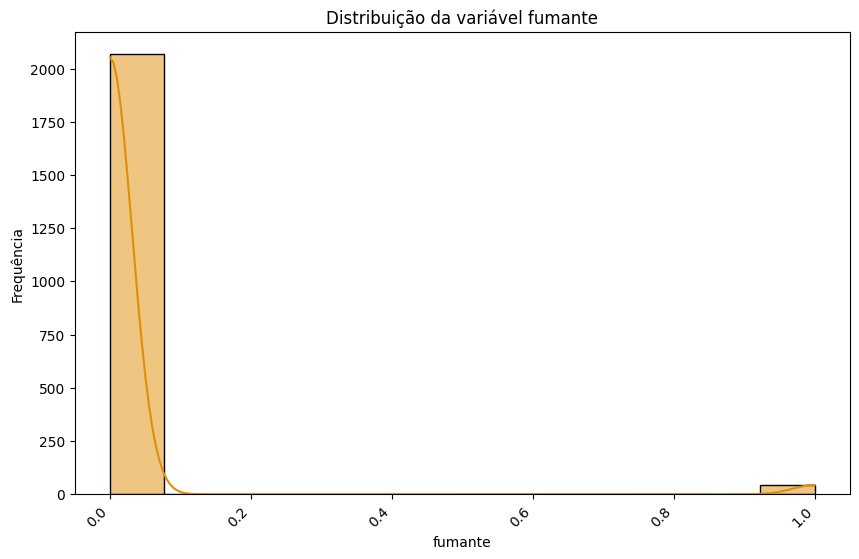

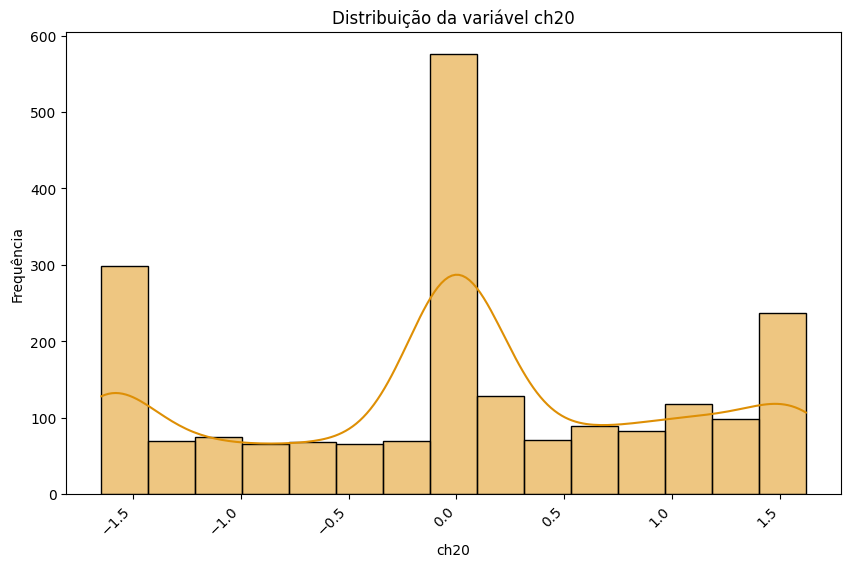

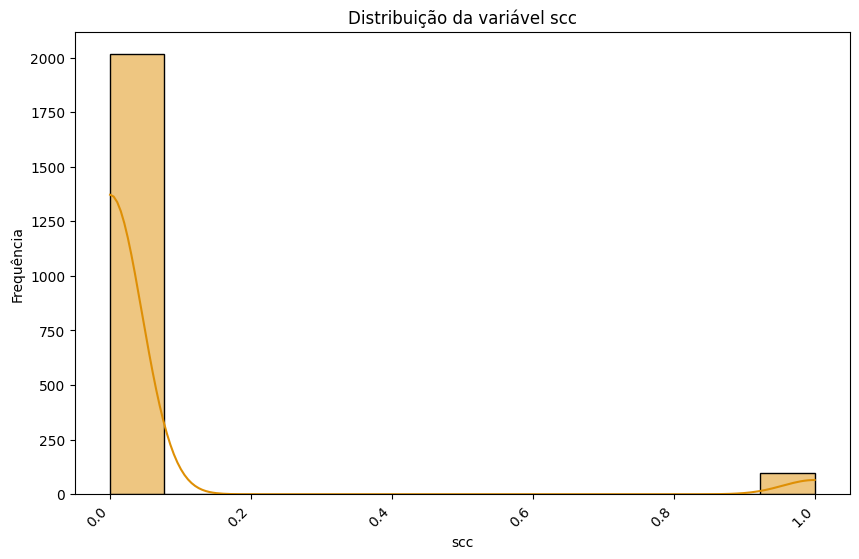

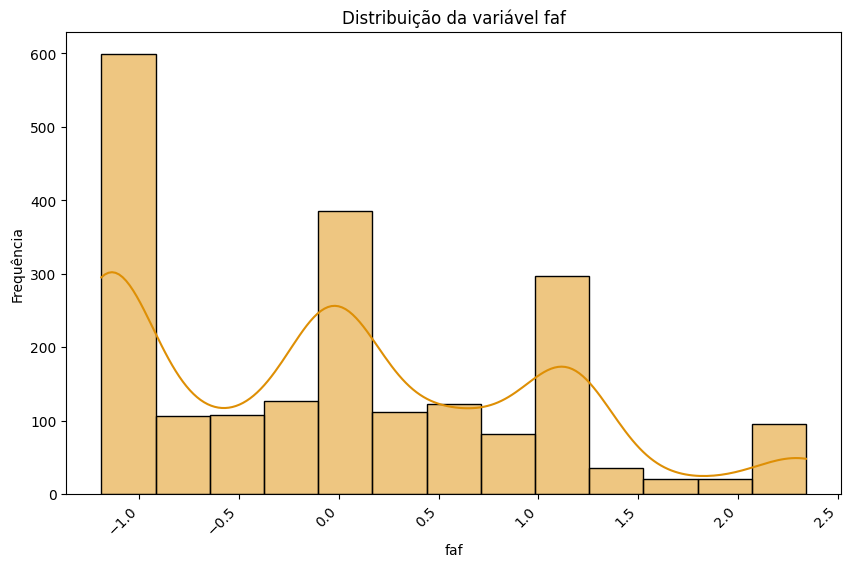

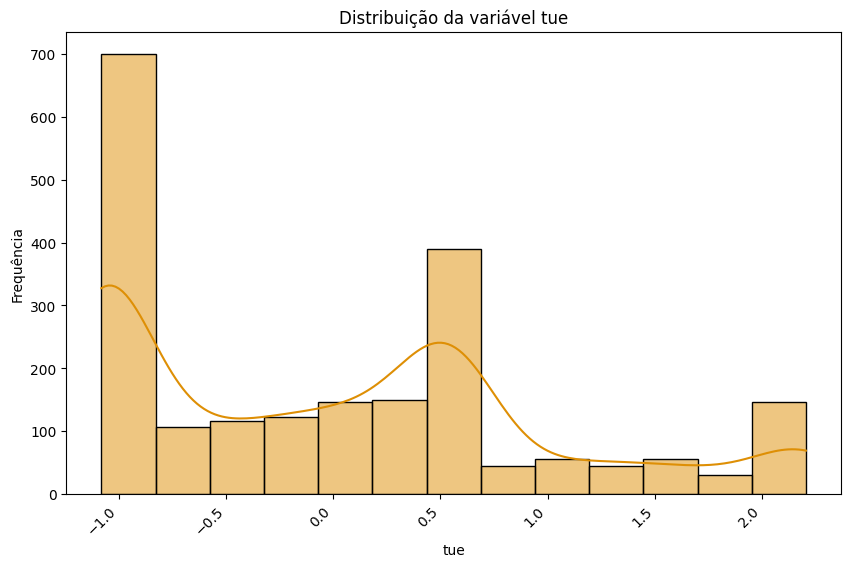

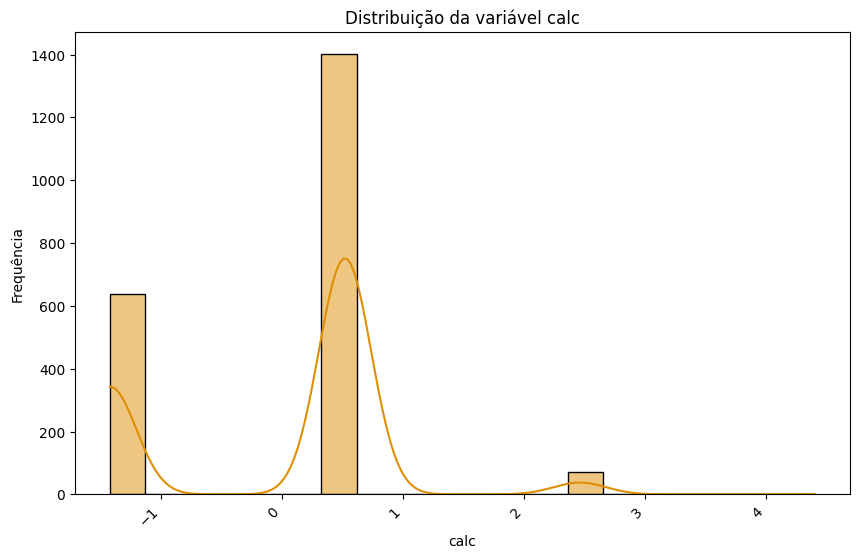

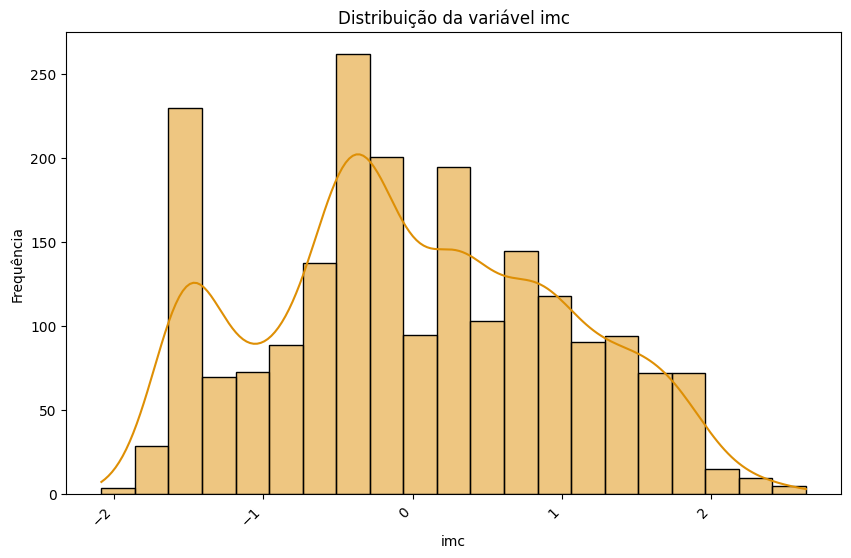

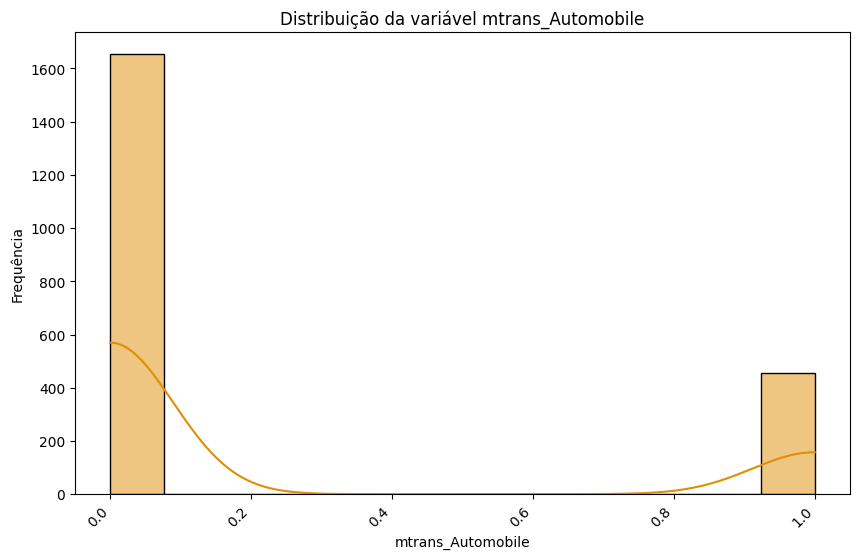

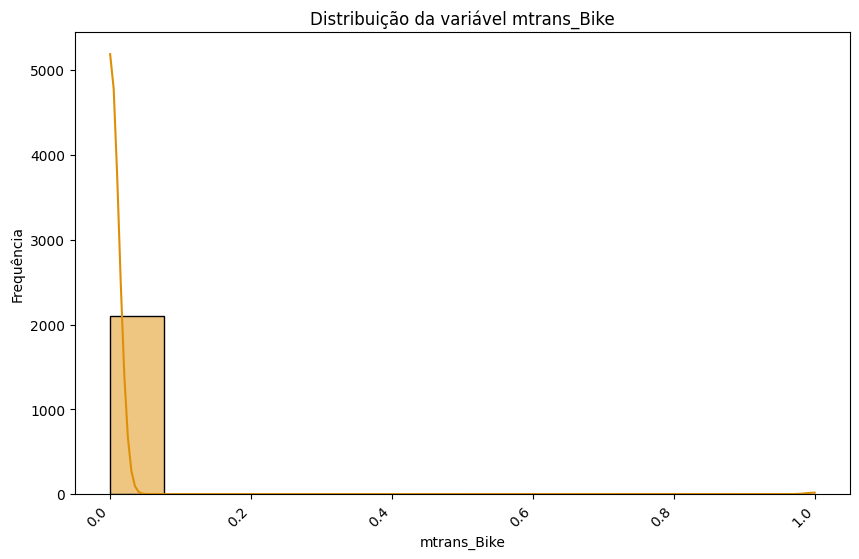

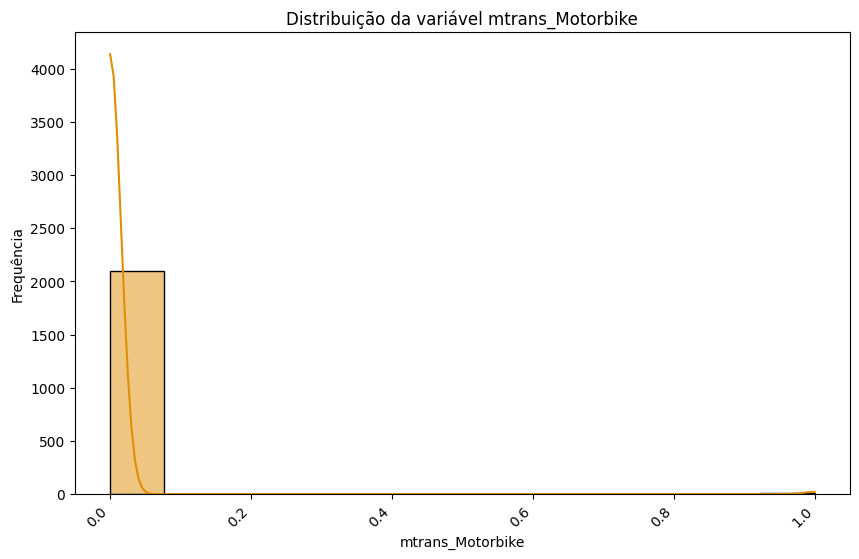

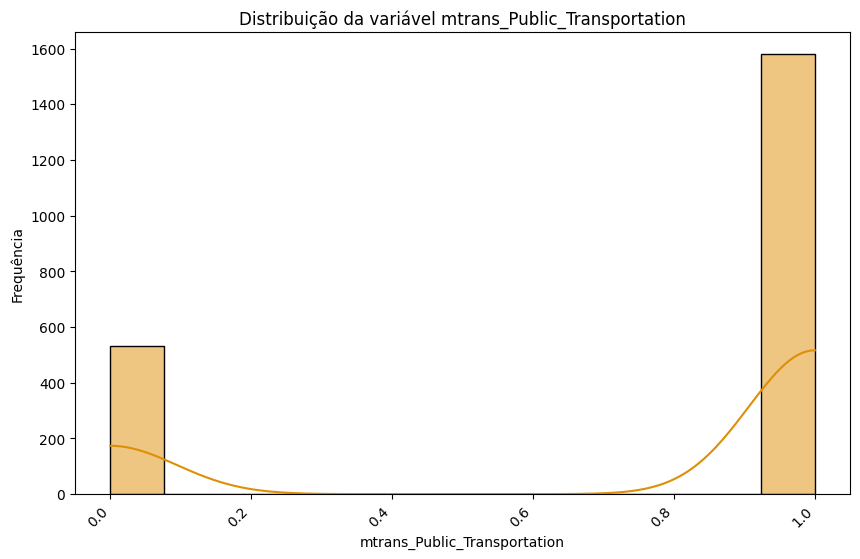

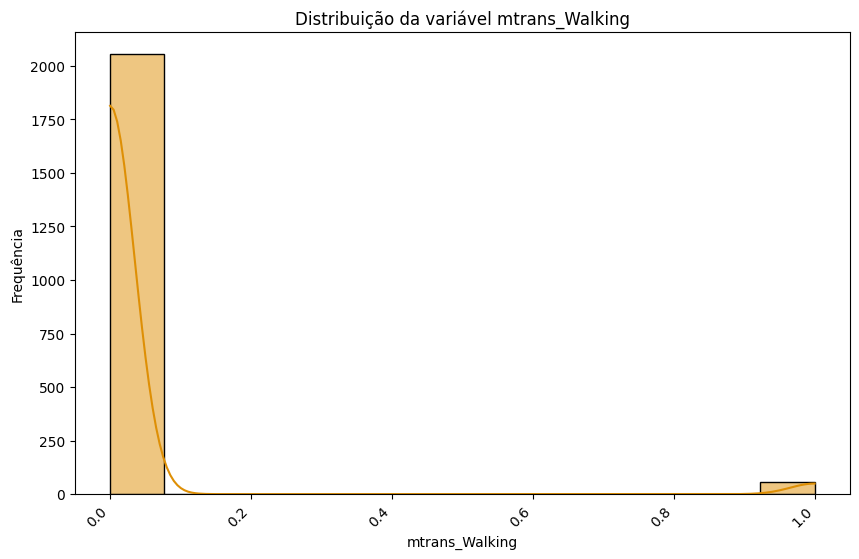

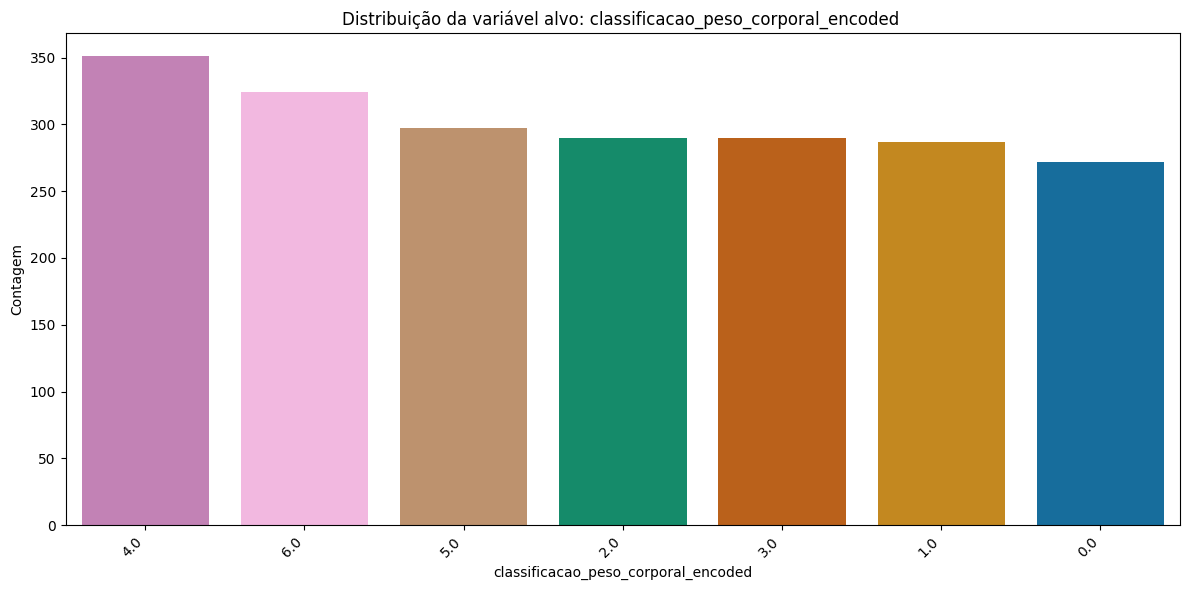

In [ ]:


for col in colunas_numericas:
    gera_histograma(df_obesidade, col, titulo=f'Distribuição da variável {col}')

gera_grafico_barras(df_obesidade, 'classificacao_peso_corporal_encoded', titulo= f'Distribuição da variável alvo: {coluna_alvo} ')

Visualiza a relação entre variáveis ​​independentes selecionadas e a variável alvo usando gráficos apropriados para entender como elas se relacionam com os níveis de obesidade.



/tmp/ipython-input-3814894315.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_obesidade, x=coluna_alvo, y=col, palette='colorblind')


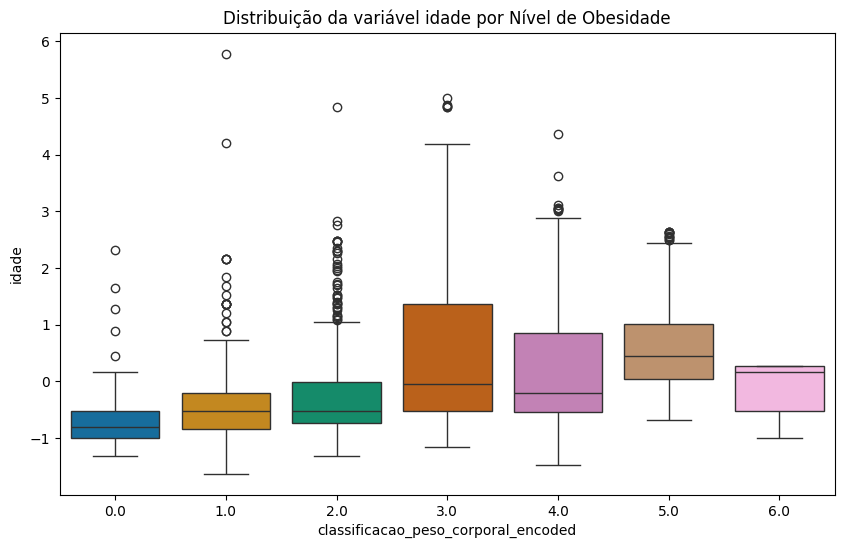

/tmp/ipython-input-3814894315.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_obesidade, x=coluna_alvo, y=col, palette='colorblind')


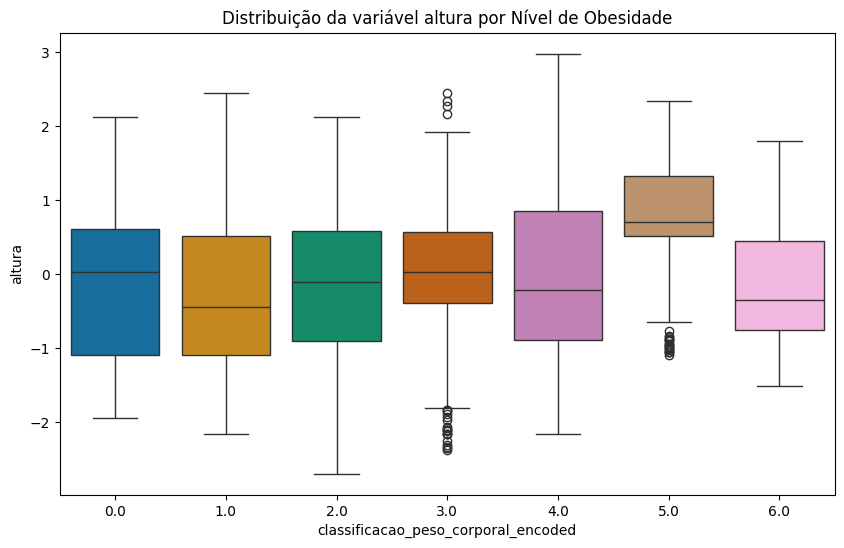

/tmp/ipython-input-3814894315.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_obesidade, x=coluna_alvo, y=col, palette='colorblind')


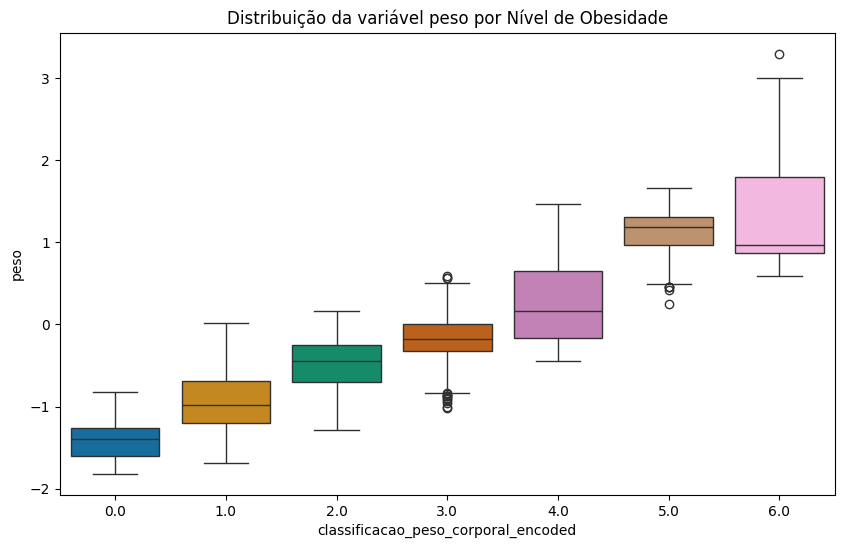

/tmp/ipython-input-3814894315.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_obesidade, x=coluna_alvo, y=col, palette='colorblind')


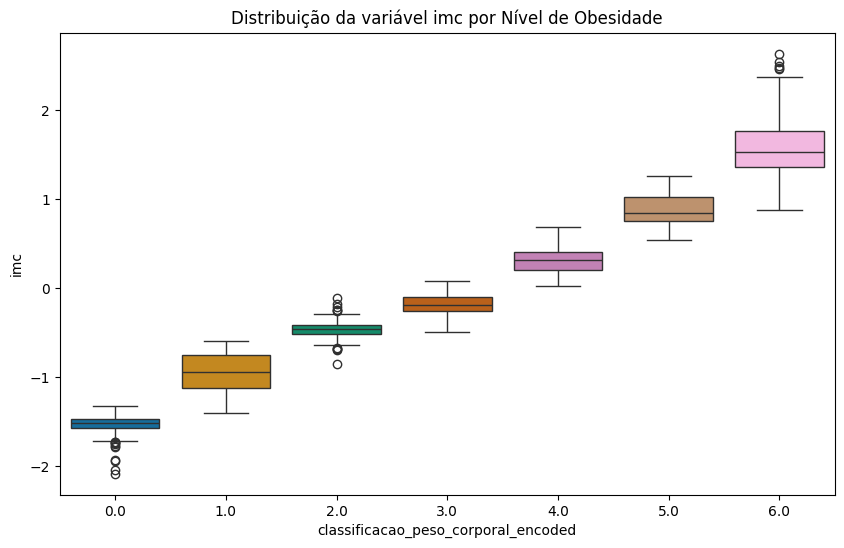

/tmp/ipython-input-3814894315.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_obesidade, x=coluna_alvo, y=col, palette='colorblind')


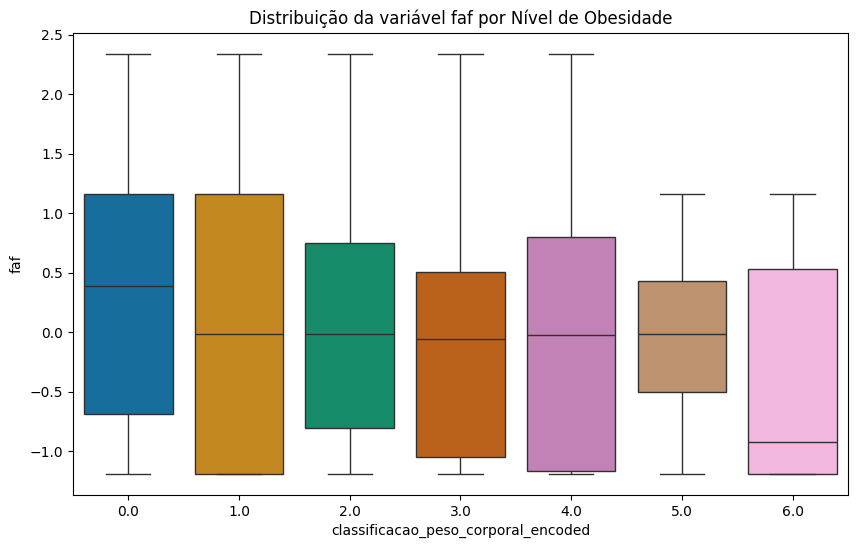

/tmp/ipython-input-3814894315.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_obesidade, x=coluna_alvo, y=col, palette='colorblind')


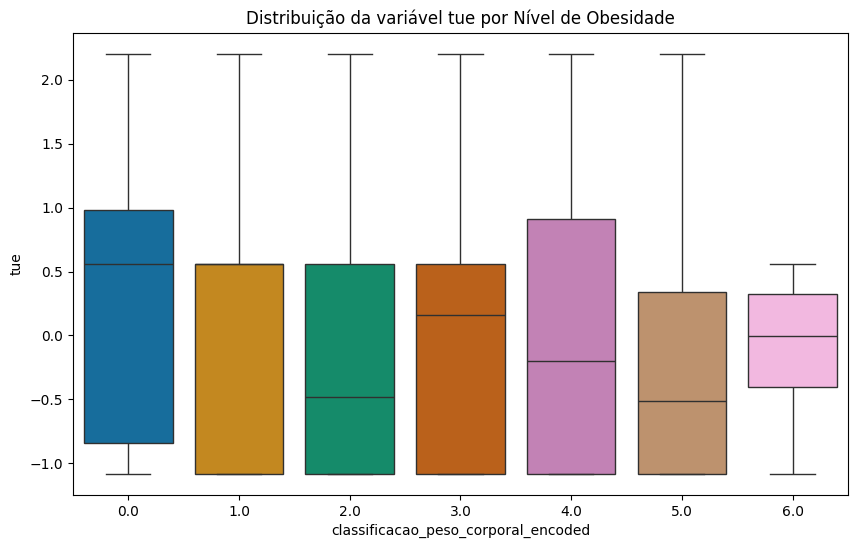

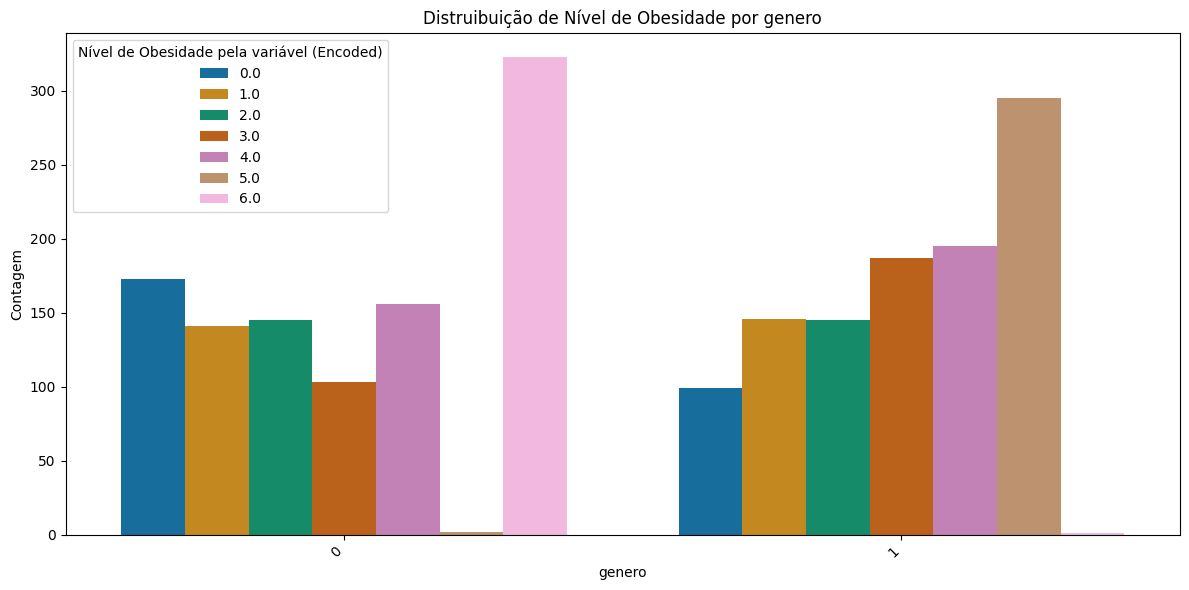

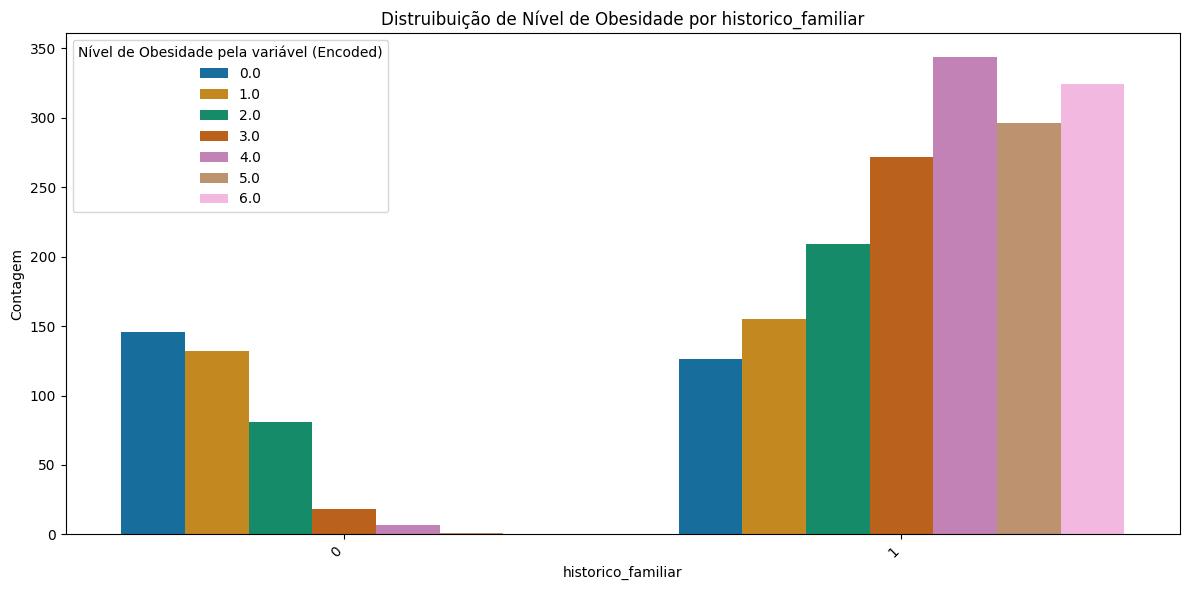

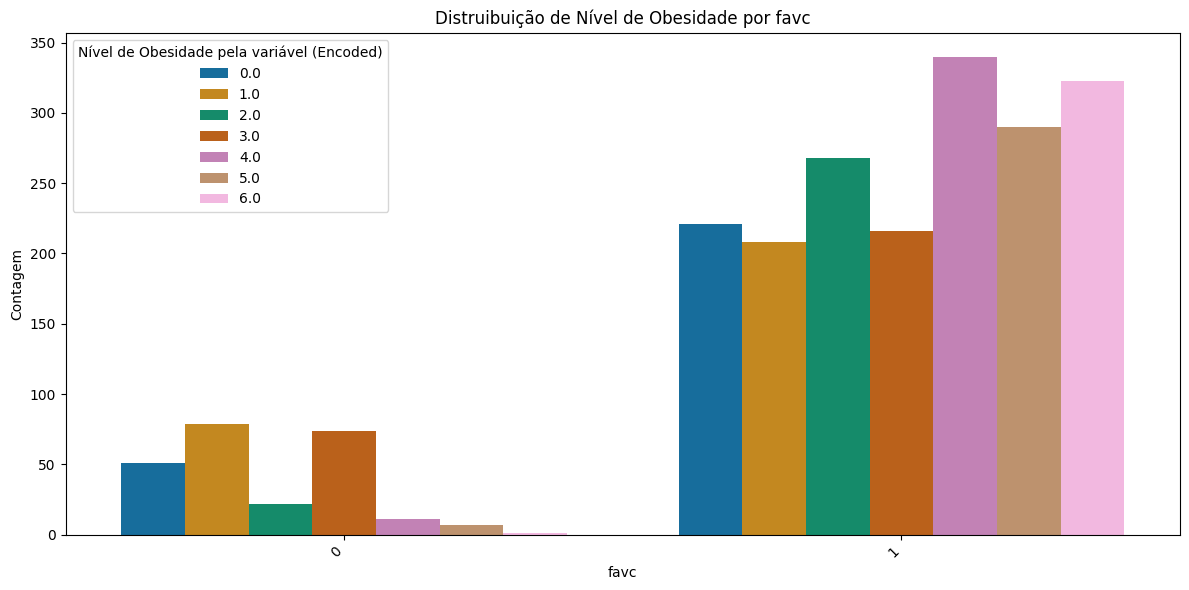

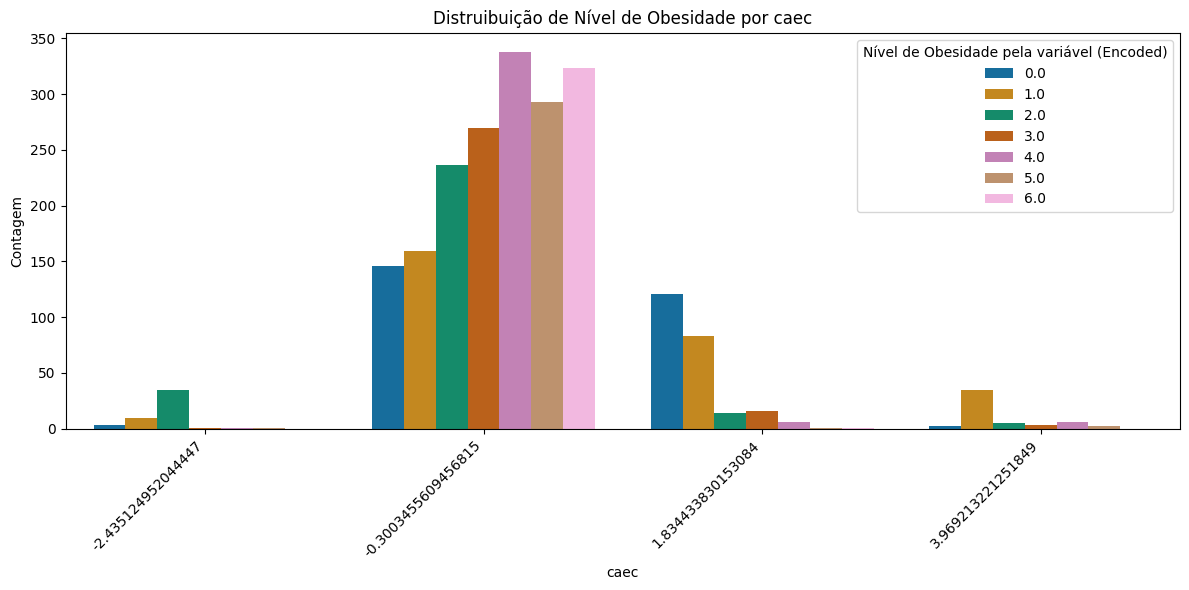

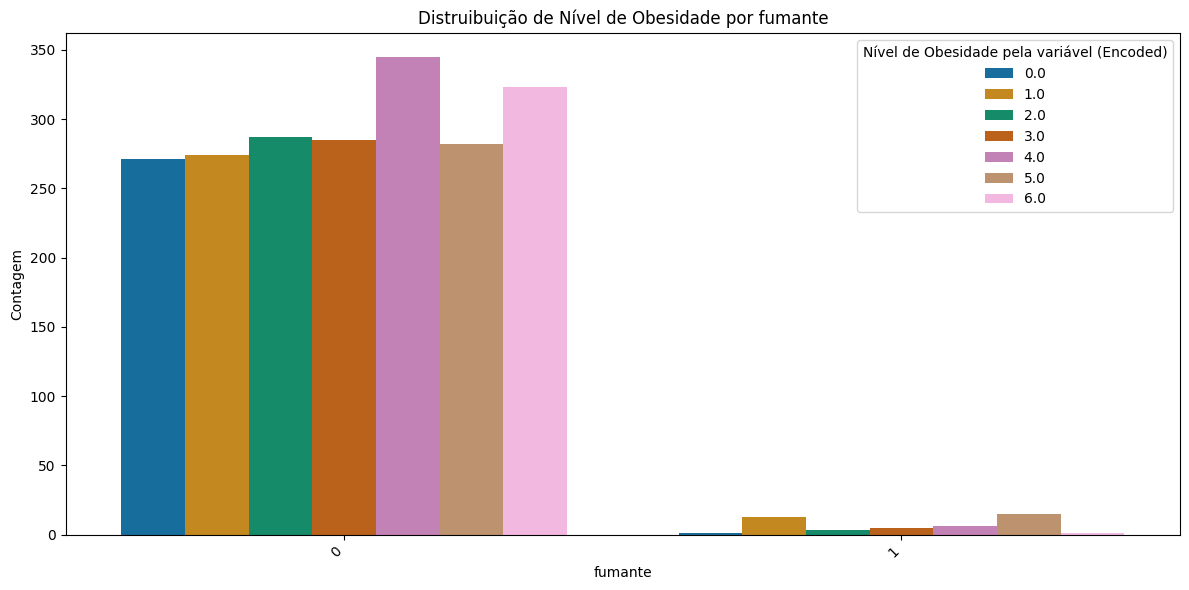

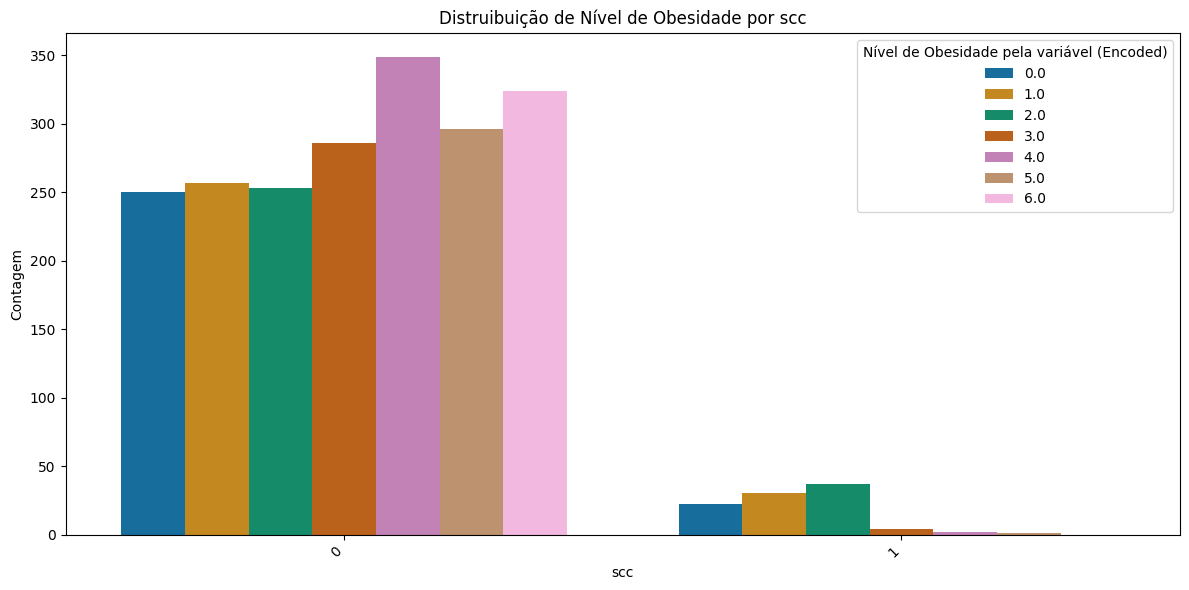

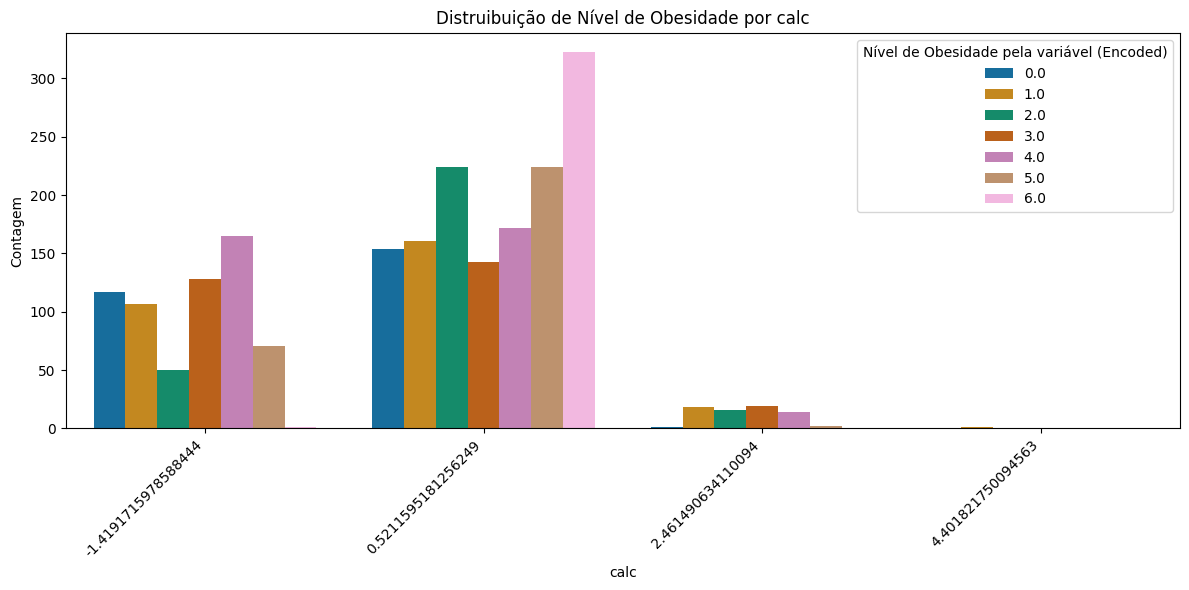

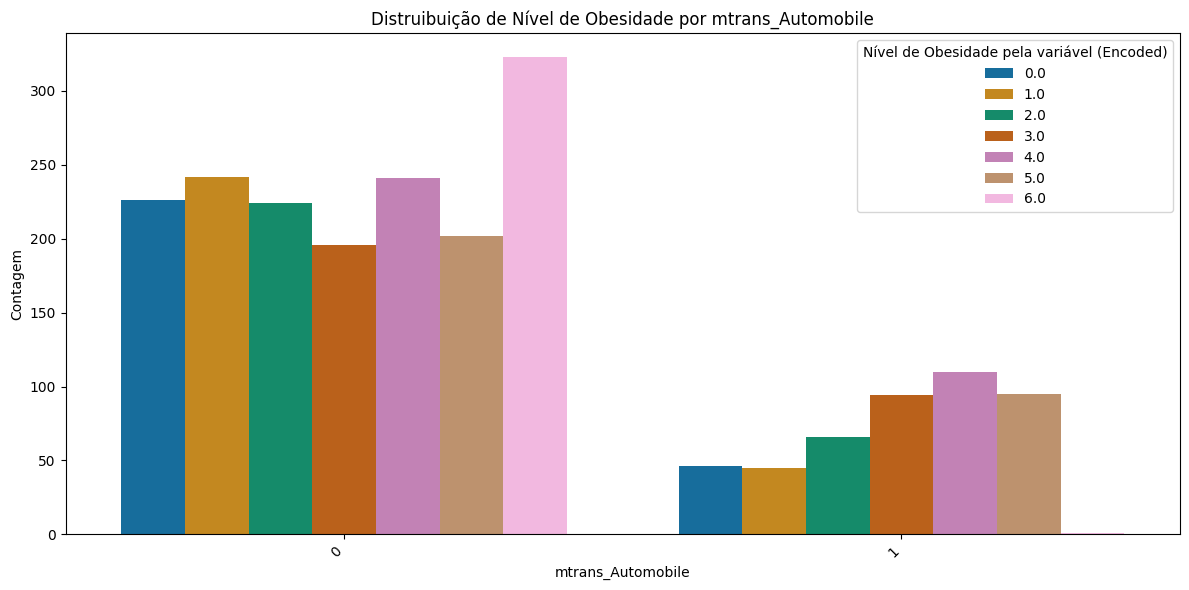

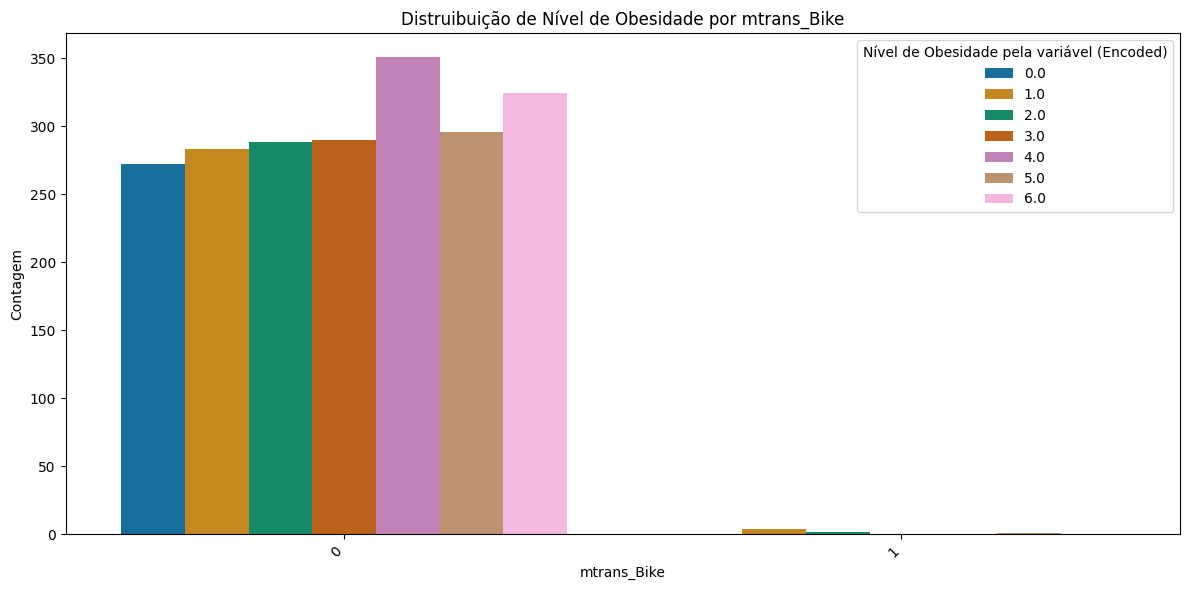

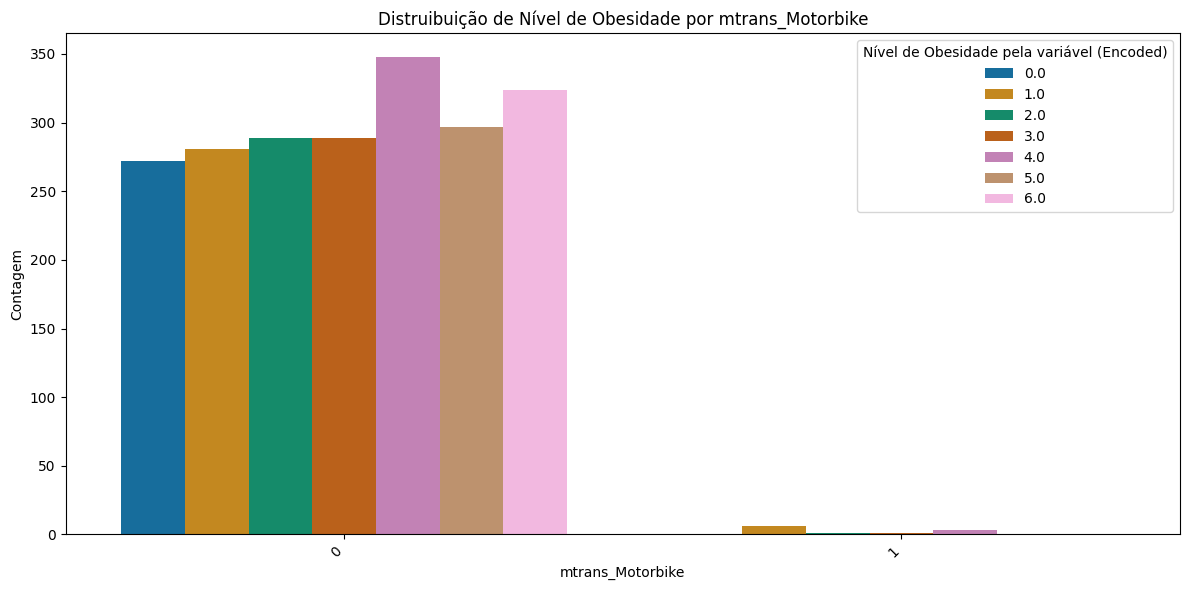

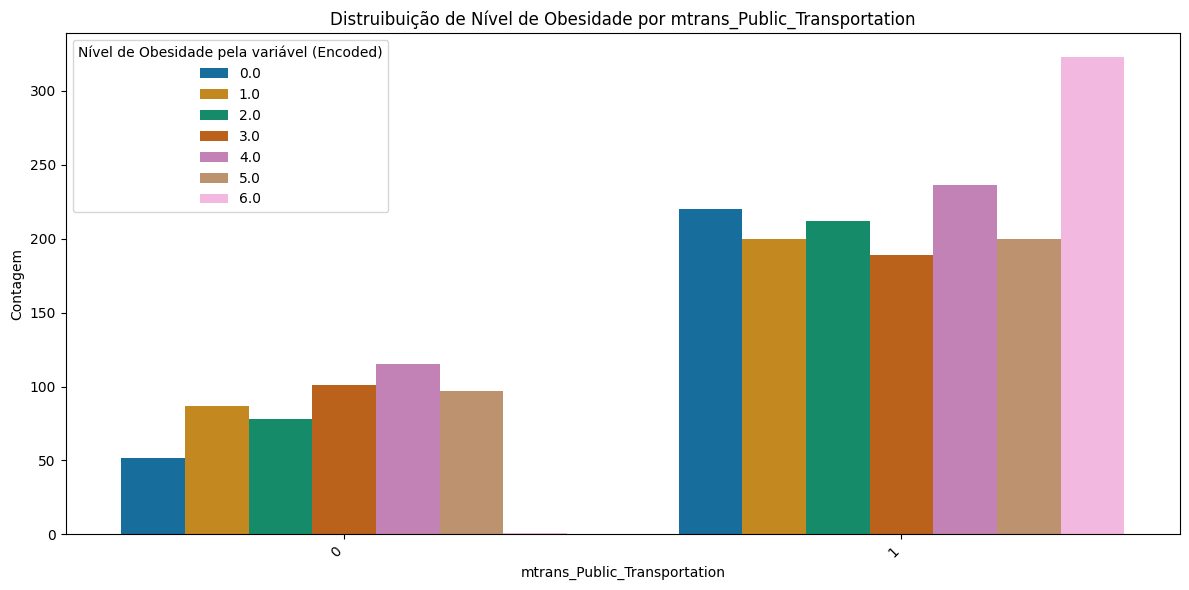

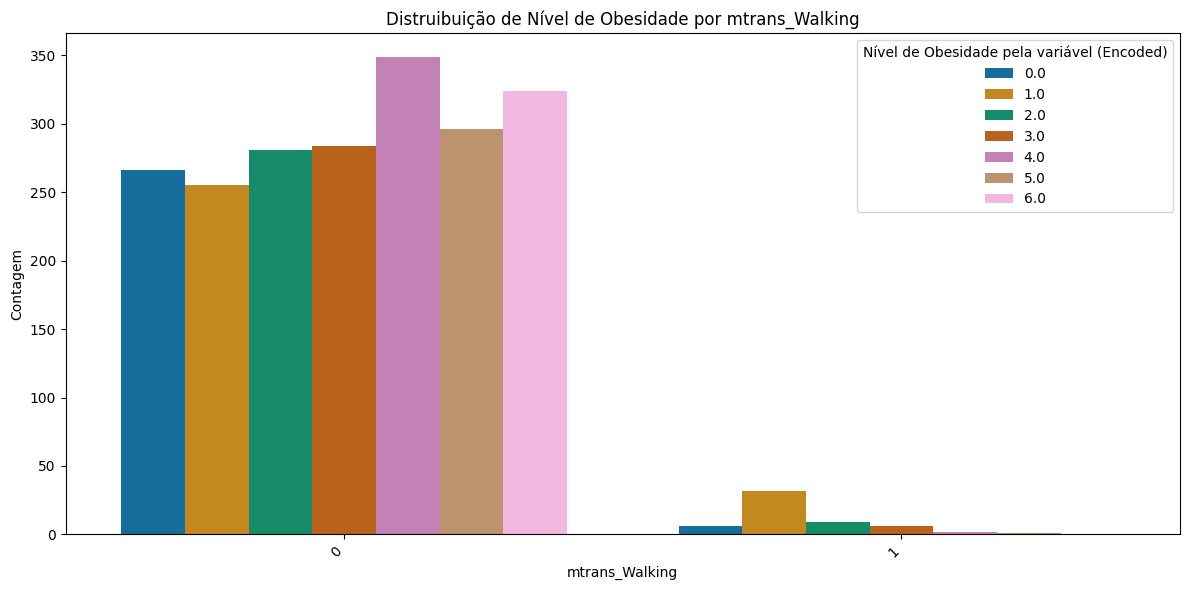

In [ ]:
# Analisa a relação entre características numéricas e alvo
variaveis_numericas_grafico = ['idade', 'altura', 'peso', 'imc', 'faf', 'tue']
for col in variaveis_numericas_grafico:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_obesidade, x=coluna_alvo, y=col, palette='colorblind')
    plt.title(f'Distribuição da variável {col} por Nível de Obesidade')
    plt.xlabel(f'{coluna_alvo}')
    plt.ylabel(col)
    plt.show()

# Analisa a relação entre características categóricas e alvo (excluindo o próprio alvo e colunas categóricas relacionadas)
variaveis_categoricas_grafico = [
    'genero',
    'historico_familiar',
    'favc',
    'caec',
    'fumante',
    'scc',
    'calc',
    'mtrans_Automobile',
    'mtrans_Bike',
    'mtrans_Motorbike',
    'mtrans_Public_Transportation',
    'mtrans_Walking'
    ]
for col in variaveis_categoricas_grafico:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_obesidade, x=col, hue= coluna_alvo, palette='colorblind')
    plt.title(f'Distruibuição de Nível de Obesidade por {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Nível de Obesidade pela variável (Encoded)')
    plt.tight_layout()
    plt.show()

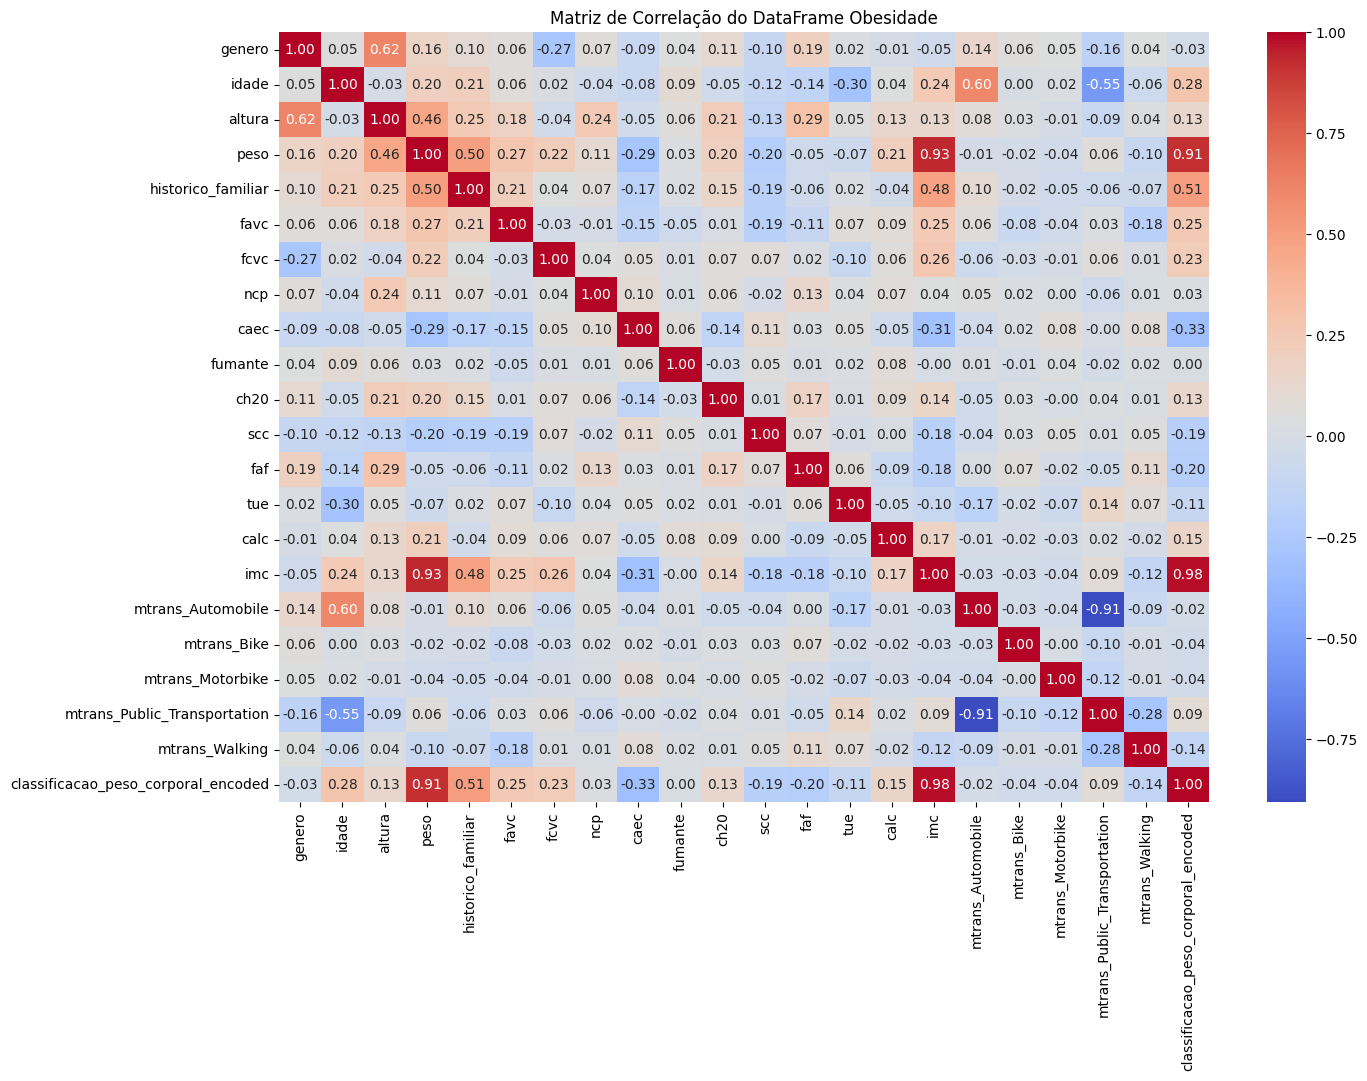

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_obesidade.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação do DataFrame Obesidade')
plt.show()

## Análise da Matriz de Correlação para Seleção de Variáveis

Variáveis com maior correlação (observadas na matriz):

*   **peso:** Espera-se uma alta correlação positiva entre peso e o nível de obesidade. Quanto maior o peso, maior a probabilidade de um nível de obesidade mais alto.
*   **altura:** A altura, em conjunto com o peso, é um fator chave no cálculo do IMC, que está diretamente relacionado à classificação de peso corporal. A correlação pode não ser tão alta quanto o peso isoladamente, mas é um componente essencial.
*   **imc:** Como o IMC é calculado a partir do peso e da altura e é a base para muitas classificações de obesidade, ele terá uma alta correlação com a variável alvo.
*   **fcvc (Consumo de vegetais):** Variáveis relacionadas a hábitos alimentares saudáveis, como o consumo de vegetais, podem ter uma correlação negativa, indicando que maior consumo está associado a níveis de obesidade mais baixos.
*   **faf (Frequência de atividade física):** Similar ao consumo de vegetais, a frequência de atividade física provavelmente terá uma correlação negativa com o nível de obesidade.
*   **caec (Consumo de alimentos entre refeições):** Este hábito alimentar pode ter uma correlação positiva com o nível de obesidade.
*   **calc (Consumo de álcool):** O consumo de álcool também pode apresentar alguma correlação positiva com o nível de obesidade.


**Seleção Inicial:**

Optamos por retirar as variáveis: `'classificacao_peso_corporal_encoded', 'classificacao_peso_corporal', 'imc', 'classificacao_imc'`



## Preparação dos dados para o modelo

### Separar os dados em conjuntos de treinamento e teste, e aplicar técnicas de balanceamento de classes, se necessário.



Define features (X) and target (y), excluding irrelevant columns, and then split the data into training and testing sets while maintaining class distribution.



In [ ]:
# Define features (X) and target (y), excluding irrelevant columns
coluna_alvo = 'classificacao_peso_corporal_encoded'
colunas_para_excluir = ['classificacao_peso_corporal', 'classificacao_imc', 'imc', coluna_alvo]
X = df_obesidade.drop(columns=colunas_para_excluir)
y = df_obesidade[coluna_alvo]

# Identify categorical columns for one-hot encoding
categorical_cols = X.select_dtypes(include='object').columns.tolist()
print("Colunas categóricas para one-hot encoding:")
print(categorical_cols)

# Apply one-hot encoding to categorical features
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y # Stratify to maintain class distribution
)

print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Check class distribution in the training set
print("\nClass distribution in y_train before SMOTE:")
display(y_train.value_counts())

Colunas categóricas para one-hot encoding:
[]

Shape of X_train: (1583, 20)
Shape of X_test: (528, 20)
Shape of y_train: (1583,)
Shape of y_test: (528,)

Class distribution in y_train before SMOTE:


,count
classificacao_peso_corporal_encoded,
4.0,263
6.0,243
5.0,223
3.0,218
2.0,217
1.0,215
0.0,204


## Seleção e treinamento do modelo

Escolher um ou mais algoritmos de classificação e treiná-los com os dados de treinamento.


**Reasoning**:
Import the necessary classification models from scikit-learn.



In [ ]:

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nShape of X_train_resampled after SMOTE:", X_train_resampled.shape)
print("Shape of y_train_resampled after SMOTE:", y_train_resampled.shape)

print("\nClass distribution in y_train_resampled after SMOTE:")
display(y_train_resampled.value_counts())




Shape of X_train_resampled after SMOTE: (1841, 20)
Shape of y_train_resampled after SMOTE: (1841,)

Class distribution in y_train_resampled after SMOTE:


,count
classificacao_peso_corporal_encoded,
5.0,263
2.0,263
1.0,263
4.0,263
3.0,263
0.0,263
6.0,263


**Reasoning**:
Instantiate and train the selected classification models using the resampled training data.



In [ ]:
# Instantiate models
log_reg = LogisticRegression(random_state=42, solver='liblinear') # Using liblinear for smaller datasets
dec_tree = DecisionTreeClassifier(random_state=42)
rand_forest = RandomForestClassifier(random_state=42)
grad_boost = GradientBoostingClassifier(random_state=42)
svm_model = SVC(random_state=42)

# Train models
log_reg.fit(X_train_resampled, y_train_resampled)
dec_tree.fit(X_train_resampled, y_train_resampled)
rand_forest.fit(X_train_resampled, y_train_resampled)
grad_boost.fit(X_train_resampled, y_train_resampled)
svm_model.fit(X_train_resampled, y_train_resampled)

print("Models trained successfully.")

Models trained successfully.


## Avaliação do modelo


Avaliar o desempenho do modelo treinado utilizando métricas apropriadas para problemas de classificação, como acurácia, precisão, recall e F1-score.


**Reasoning**:
Import the necessary classification metrics and create a dictionary of the trained models.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a dictionary of the trained models
trained_models = {
    "Logistic Regression": log_reg,
    "Decision Tree": dec_tree,
    "Random Forest": rand_forest,
    "Gradient Boosting": grad_boost,
    "SVM": svm_model
}

**Reasoning**:
Iterate through the trained models, make predictions, calculate evaluation metrics, and print the results for each model.



In [ ]:
for name, model in trained_models.items():
    print(f"Evaluating {name}...")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') # Using weighted average for multi-class
    recall = recall_score(y_test, y_pred, average='weighted')     # Using weighted average for multi-class
    f1 = f1_score(y_test, y_pred, average='weighted')           # Using weighted average for multi-class

    # Print metrics
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print("-" * 30)

Evaluating Logistic Regression...
  Accuracy: 0.7576
  Precision: 0.7580
  Recall: 0.7576
  F1-score: 0.7550
------------------------------
Evaluating Decision Tree...
  Accuracy: 0.9261
  Precision: 0.9273
  Recall: 0.9261
  F1-score: 0.9262
------------------------------
Evaluating Random Forest...
  Accuracy: 0.9451
  Precision: 0.9505
  Recall: 0.9451
  F1-score: 0.9460
------------------------------
Evaluating Gradient Boosting...
  Accuracy: 0.9489
  Precision: 0.9504
  Recall: 0.9489
  F1-score: 0.9490
------------------------------
Evaluating SVM...
  Accuracy: 0.9129
  Precision: 0.9156
  Recall: 0.9129
  F1-score: 0.9138
------------------------------


## Serialização do model

Salvar o modelo treinado para uso futuro.


**Reasoning**:
Import the necessary library for saving the model, choose the best performing model, define the filename, and save the model using joblib.dump().



In [ ]:
import joblib

# Based on the evaluation results, Gradient Boosting performed best.
best_model = trained_models["Gradient Boosting"]

# Define a filename for the serialized model
filename = 'best_obesity_model.joblib'

# Save the chosen model to the specified file
joblib.dump(best_model, filename)

print(f"Model saved successfully to {filename}")

Model saved successfully to best_obesity_model.joblib


## Treinamento do modelo com variáveis selecionadas por importância


Selecionar as variáveis mais importantes com base na análise de feature importance.

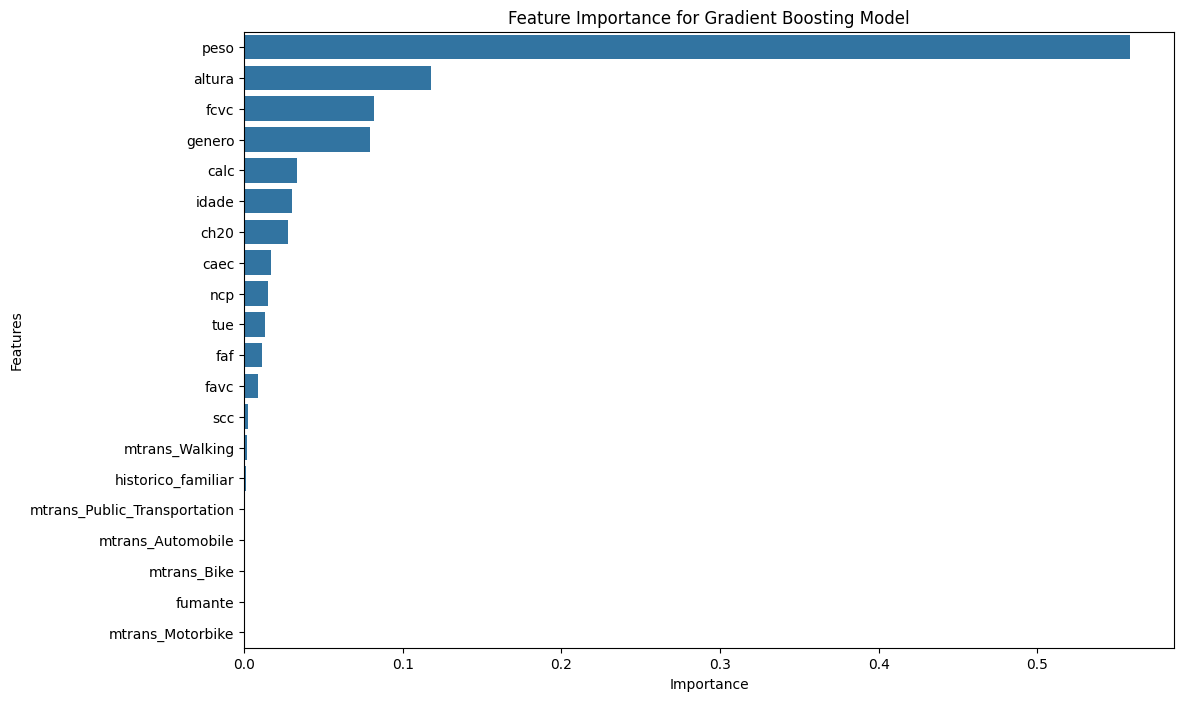

In [ ]:
# Get feature importances from the Gradient Boosting model
feature_importances = best_model.feature_importances_

# Create a pandas Series for better visualization
feature_importances_series = pd.Series(feature_importances, index=X_train_resampled.columns)

# Sort the features by importance
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances.values, y=sorted_feature_importances.index)
plt.title('Feature Importance for Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
# Define a threshold for feature importance (you can adjust this value)
# Let's choose features with importance greater than 0.01 as an example
important_features = sorted_feature_importances[sorted_feature_importances > 0.01].index.tolist()

print("Selected important features:")
print(important_features)

Selected important features:
['peso', 'altura', 'fcvc', 'genero', 'calc', 'idade', 'ch20', 'caec', 'ncp', 'tue', 'faf']


### Subtask:
Preparar os dados (X e y) usando apenas as variáveis selecionadas.

In [ ]:
# Select only the important features from the original DataFrame
X_selected = df_obesidade[important_features]
y_selected = df_obesidade['classificacao_peso_corporal_encoded']

# Identify categorical columns within the selected features to ensure proper handling before splitting/SMOTE
categorical_cols_selected = X_selected.select_dtypes(include='object').columns.tolist()
print("\nCategorical columns in selected features:")
print(categorical_cols_selected)

# Apply one-hot encoding to the selected features
X_selected = pd.get_dummies(X_selected, columns=categorical_cols_selected, drop_first=True)

# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    X_selected, y_selected, test_size=0.25, random_state=42, stratify=y_selected
)

print("\nShape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)
print("Shape of y_train_selected:", y_train_selected.shape)
print("Shape of y_test_selected:", y_test_selected.shape)


Categorical columns in selected features:
[]

Shape of X_train_selected: (1583, 11)
Shape of X_test_selected: (528, 11)
Shape of y_train_selected: (1583,)
Shape of y_test_selected: (528,)


### Subtask:
Aplicar SMOTE ao conjunto de treinamento com as variáveis selecionadas.

In [ ]:
# Apply SMOTE to the resampled training data
smote_selected = SMOTE(random_state=42)
X_train_selected_resampled, y_train_selected_resampled = smote_selected.fit_resample(
    X_train_selected, y_train_selected
)

print("Shape of X_train_selected_resampled after SMOTE:", X_train_selected_resampled.shape)
print("Shape of y_train_selected_resampled after SMOTE:", y_train_selected_resampled.shape)

print("\nDistribution of classes in y_train_selected_resampled after SMOTE:")
display(y_train_selected_resampled.value_counts())

Shape of X_train_selected_resampled after SMOTE: (1841, 11)
Shape of y_train_selected_resampled after SMOTE: (1841,)

Distribution of classes in y_train_selected_resampled after SMOTE:


,count
classificacao_peso_corporal_encoded,
5.0,263
2.0,263
1.0,263
4.0,263
3.0,263
0.0,263
6.0,263


### Subtask:
Treinar o modelo Gradient Boosting com as variáveis selecionadas e balanceadas.

In [ ]:
# Instantiate and train the Gradient Boosting model with selected features
grad_boost_selected = GradientBoostingClassifier(random_state=42)
grad_boost_selected.fit(X_train_selected_resampled, y_train_selected_resampled)

print("Gradient Boosting model trained successfully with selected features.")

Gradient Boosting model trained successfully with selected features.


### Subtask:
Avaliar o desempenho do modelo treinado com as variáveis selecionadas.

In [ ]:
# Make predictions on the test set
y_pred_selected = grad_boost_selected.predict(X_test_selected)

# Calculate metrics
accuracy_selected = accuracy_score(y_test_selected, y_pred_selected)
precision_selected = precision_score(y_test_selected, y_pred_selected, average='weighted')
recall_selected = recall_score(y_test_selected, y_pred_selected, average='weighted')
f1_selected = f1_score(y_test_selected, y_pred_selected, average='weighted')

# Print metrics
print("Evaluation Metrics for Gradient Boosting Model with Selected Features:")
print(f"  Accuracy: {accuracy_selected:.4f}")
print(f"  Precision: {precision_selected:.4f}")
print(f"  Recall: {recall_selected:.4f}")
print(f"  F1-score: {f1_selected:.4f}")

Evaluation Metrics for Gradient Boosting Model with Selected Features:
  Accuracy: 0.9413
  Precision: 0.9432
  Recall: 0.9413
  F1-score: 0.9415
